# Milestone 3 - Report
------
In this notebook we are going to summarize what was done in [Milestone 2](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/Milestone%202.ipynb) and explain all that was done for the final Milestone. The focus at this point of the project was placed on constructing the awareness model using our different metrics and the final datastory. 

Note that all the maps presented in this notebook were generated using javascript in order to be interactive and can be found on our website 

In [1]:
import os
import json
import time
import folium
import branca
import jenkspy
import pickle
import unicodedata
import collections
import numpy as np
import pandas as pd
from scipy import spatial, stats
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting
from IPython.display import Image

%matplotlib inline

## 0. Abstract

*What's the motivation behind your project? A 150 word description of the project idea, goals, dataset used. What story you would like to tell and why?*

Major events happen on a regular basis all around the world, some involving high number of casualties but the resulting reaction on the international scale is often far from proportional. Most of the time the largest reaction comes from the place where the incident occurred or places which are closeby. The objective would be to create an awareness map, and determine why people react to an event. From that we would attempt to define an awareness metric. We want to see how factors other than physical proximity come into play such as country, culture, language, religion. With this we could determine which country has the highest level of international awareness. The project would require the Twitter API to acquire hashtag specific tweets with geolocation and therefore measure the awareness and reactions of different communities to a given event. GDELT would be used to recover standardised information regarding different events.
____
____
____


# 1. Recapitulation of [Milestone 2](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/Milestone%202.ipynb)

To recap what was done in the previous milestone, here we present a brief summary of the previous notebook which can be found [here](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/Milestone%202.ipynb)
____

## 1.1 Tweet Acquisition
A lot of time was spent acquiring the Tweets for two main reasons : 
- The Twitter dump did not contain the geolocations of the tweets or the users and only containecd 10% of all tweets for a given period. Given that users to not necessarily give their location we wanted to avoid cases where we would not have enough overall located tweets. 
- The Twitter API does not permit the recovery of tweets which are over 1 week old when searching for tweets with a given hashtag around a specific date. 

That is why a significant amount of time was put into recovering the tweets through webscraping using phantom js with random scrolling time and random breaks to avoid being blocked by Twitter.

The tweets were acquired based on their hashtags, all the while making sure to have a wide range of hashtags in different languages. Here is the link to the file where we put all the hashtags for each event: https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/TweetAcquisition/Hashtags%20Per%20Event.docx

____

## 1.2. Tweet Geolocalisation

Once the tweets were recovered we only kept those for which we had either the geolocalisation of the tweets itself or of the user. As the locations are manually input, they are not standardized and the corresponding location needed to be determined. 

The first step was therefore to format the strings by removing all special characters as setting everything to lower case for example.  Afterwards, we created multiple mappings which were used in the order presented as they represent the confidence in the given method : 
- A country mapper which uses multiple variations of the country name (different spellings and languages) to determine the country it corresponds to with the given ISO2 code
- A capital mapper which maps the capital of a country to the ISO2 code
- A first city mapper where duplicates were removed as there are multiple cities in the world with the same name (example : Torronto in Canada, the US and Australia). 
- A final city mapper with all the cities of all the countries in the world using the database provided here: http://download.geonames.org/export/dump/


## 1.3. Visualization of the Reaction For An Event

We then observed for one of the selected events the number of related tweets on a Chloropleth map. This helped us note certain issues in the mappings (high number of tweets in Antarctica for example). 

Here is the number of reactions per each event with other interesting data. This was computed in the [Observing Hashtags and Locations](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Observing%20Hashtags%20and%20Locations.ipynb)

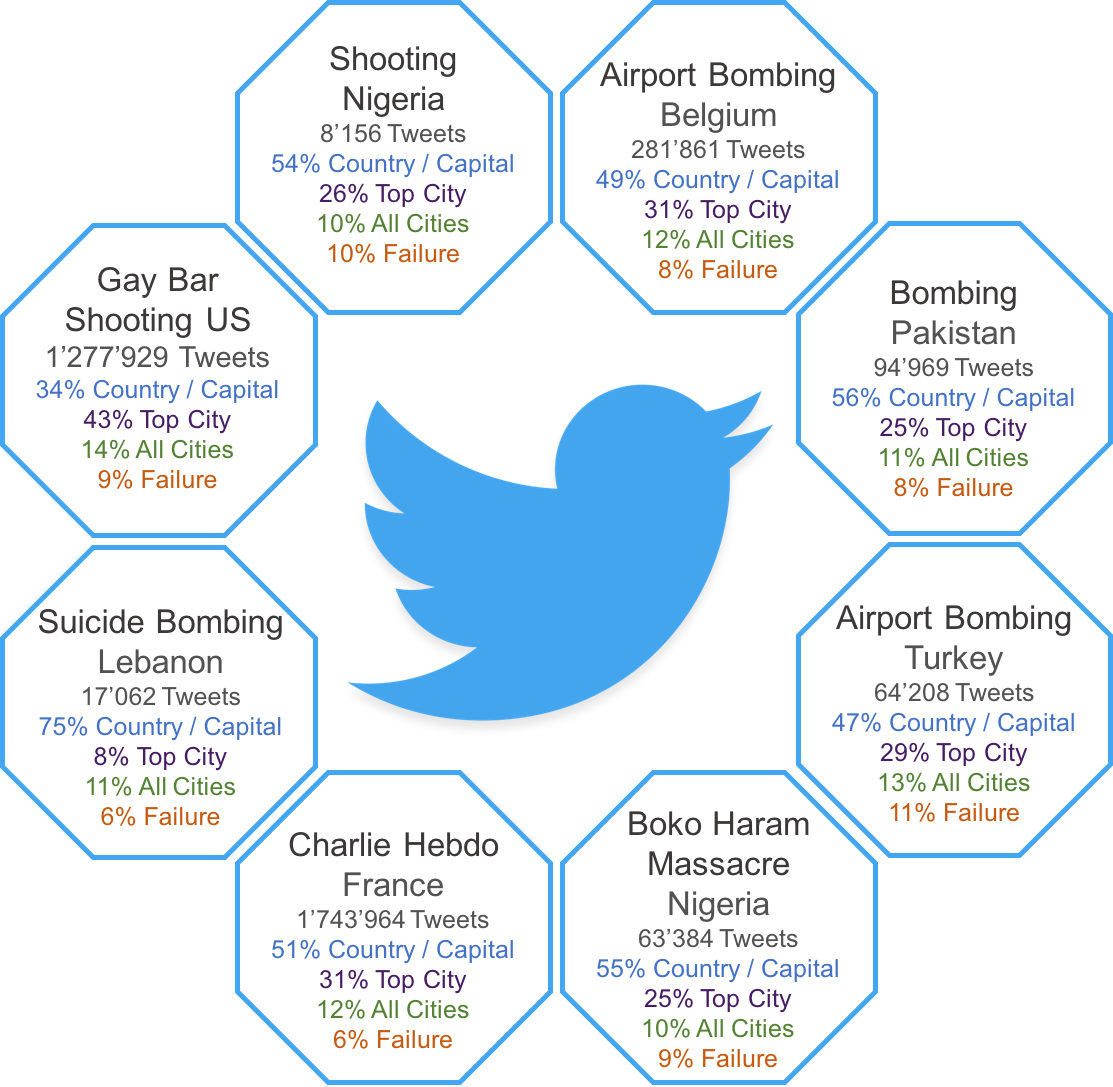

In [2]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "event_reactions.png"), width=600)

## 1.4. Enriching the Data 

To create our awareness model we wanted to recover information which could be used to determine a sort of distance between the different countries, that is why we recovered for all countries: 
- area
- ISO2
- ISO3
- languages
- border countries
- latitude and longitude
- language_codes
- Internet users
- population
- GDP
- GDP per capita
- religions
- government types
- population in poverty
- unemployment rate

As you can see, we have more features than we had originally presented in Milestone 2. That's because we realized that one of the datasets we used had a lot more (and more complete) information that was of our interest. After all, the 4 datasets that we were using originally ended up being just two, which are these:

- Dataset 1: https://github.com/mledoze/countries
- Dataset 2: https://github.com/opendatajson/factbook.json

To see all the detailed process of the extraction of the data see "Data enriching.ipynb".

____
____
____

# 2. Improving the Mappings

One main issue with the mapping up until now is that there were redundancies which were not correctly handled. At the time of Milestone 2 we would just go through the complete mapping sequentially and stop at the first match. As there were duplicates there was no guarantee that the city found was the most coherent. That is why we corrected the mapping to take into account the population of the different cities which was also provided in the GeoNames database http://download.geonames.org/export/dump/. Therefore when there are multiple cities with the same name in different countries, we only keep the city with the largest population as it would be the most probable. 

We also replaced our intermediate city mapping with a mapping containing the top 20'000 cities in the world (and therefore the most probable). With appoximately 200 countries this corresponds to around 100 cities per country. 

For more details on how this was done please refer to Milestone2 for the basic methods implemented and to the individual notebooks for the modifications since. 

Refer to the following notebooks :
- [Constructing the Mappings](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Constructing%20the%20Mappings.ipynb)
- [Intermediate Mapping With GeoNames](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Intermediate%20Mapping%20With%20GeoNames.ipynb)
- [Getting the Geocodes For The Tweets](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Geocoding%20Tweets%20Using%20the%20Mappings.ipynb)
- [Determining Number of Tweets Per Event](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Determining%20Number%20of%20Tweets%20Per%20Event.ipynb)
- [Observing Hashtags and Locations](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeocodingTweets/Observing%20Hashtags%20and%20Locations.ipynb)


____
____
____

# 3. Metrics For the Awareness Model

To create our model we originally planned to construct a graph linking all countries where the weights of the segments would represent the proximity between countries in terms of awareness to major events. 

For that we used the dataset containing all the information regarding the countries and looked to give numeric values to all the different categories mentioned previously and a few new ones: 

1. Languages
2. Governments 
3. Distances between countries :
    - Birds eye view distances 
    - Hop matrix : the number of countries which separate two given countries. This method had the problem of not accounting for the real area extention of the countries in between. For example, the distance between Finland and China is small because from Finland we only have to cross Russia to get to China, while in reality they are very separated.
  
    - Normalized Adj matrix : a matrix which gives the neighboring countries with a normalizing factor to account for multiple countries on the border
    - Flight routes between countries
4. Religion
5. Population, Area, GDP, Internet Users etc...


What needed to be taken into account here is that we have many variables which are categoric. Therefore we needed to find a way to attribute numeric values in order to construct the final graph.

Remark : most of the information was extracted from the CIA factbook as it is a complete and realiable source (https://github.com/opendatajson/factbook.json).

____

## 3.1. Languages

Languages are representative of culture and most of the time, countries which speak the same language have a given proximity. That is why this metric was used to create the graph. 

Two main possibilities presented themselves :
- binary : if two countries have the same official language then they are linked
- more informed : some languages are similar in the sense of understanding the other language, learning it, etc. That is why we wanted to take into account Linguistic distances. Unfortunately this is a current research topic and there is no database which gives the Linguistic distances between all the official languages of all countries. Certain databases exist linking English to other languages but this is not sufficient for our application. That is why we decided to use another metric, albeit more abstact, which is to say the phylogenetic trees linking languages together. 


Using the phylogenetic trees taken here http://glottolog.org/glottolog/family, we were able to construct a distance metric and compute the distances between all languages as can be seen below. The notebook handling this can be found here: https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/LinkingLanguages/Linking%20Languages.ipynb

In [3]:
# Matrix of distances between languages
dist_languages = pd.read_pickle(os.path.join(os.getcwd(), 'LinkingLanguages', 'dist_languages.pkl'))
dist_languages.head()

,Ndau,Malay,Dgernesiais,Greek,Rundi,Polish,Swiss German,Ndonga,Romanian,German,...,Zimbabwean Ndebele,Arabic,Bengali,Galician,Portuguese,Fijian,Korean,Uzbek,Jerriais,Luba-Lulua
Ndau,0.000000,inf,inf,inf,9.000000,inf,inf,10.000000,inf,inf,...,8.000000,inf,inf,inf,inf,inf,inf,inf,inf,10.000000
Malay,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,9.000000,inf,inf,inf,inf
Dgernesiais,inf,inf,0.000000,18.000000,inf,21.000000,25.000000,inf,14.000000,22.000000,...,inf,inf,23.000000,23.000000,14.000000,inf,inf,inf,2.000000,inf
Greek,inf,inf,18.000000,0.000000,inf,7.000000,11.000000,inf,10.000000,8.000000,...,inf,inf,9.000000,9.000000,16.000000,inf,inf,inf,18.000000,inf
Rundi,9.000000,inf,inf,inf,0.000000,inf,inf,13.000000,inf,inf,...,11.000000,inf,inf,inf,inf,inf,inf,inf,inf,13.000000


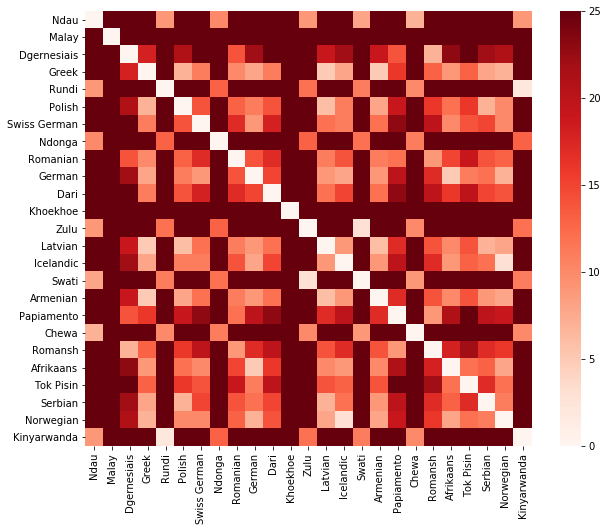

In [4]:
# Heatmap of language distances between languages
plt.figure(figsize=[10,8])
sns.heatmap(dist_languages.iloc[:25,:25],cmap="Reds", vmin=0., vmax=25.);

From this language distance matrix we were able to compute a standardized distance between all countries. 

The idea is the following :
- if countries have an official language in common, set the distance to 0
- else get the distances between the official languages and compute the average of the non infinite distances. 
- else set the distance to inf


In [5]:
# Matrix of distances between countries
country_dist_languages = pd.read_pickle(os.path.join(os.getcwd(), 'LinkingLanguages', 'country_dist_languages.pkl'))
country_dist_languages.head()

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.0,17.5,13.5,17.5,16.5,12.5,12.5,inf,13.5,15.0,...,17.5,17.5,inf,18.500000,18.5,17.5,inf,15.5,17.5,16.500000
AF,17.5,0.0,20.0,15.0,13.0,7.0,16.0,10.000000,18.0,9.5,...,15.0,15.0,inf,17.666667,21.0,15.0,10.000000,14.0,15.0,13.000000
AO,13.5,20.0,0.0,23.0,21.0,15.0,6.0,inf,6.0,17.5,...,23.0,23.0,inf,20.333333,13.0,23.0,inf,22.0,23.0,21.666667
AI,17.5,15.0,23.0,0.0,12.0,10.0,19.0,inf,21.0,12.5,...,0.0,0.0,inf,0.000000,24.0,0.0,inf,0.0,0.0,0.000000
AX,16.5,13.0,21.0,12.0,0.0,8.0,17.0,inf,19.0,10.5,...,12.0,12.0,inf,16.000000,22.0,12.0,inf,11.0,12.0,12.000000


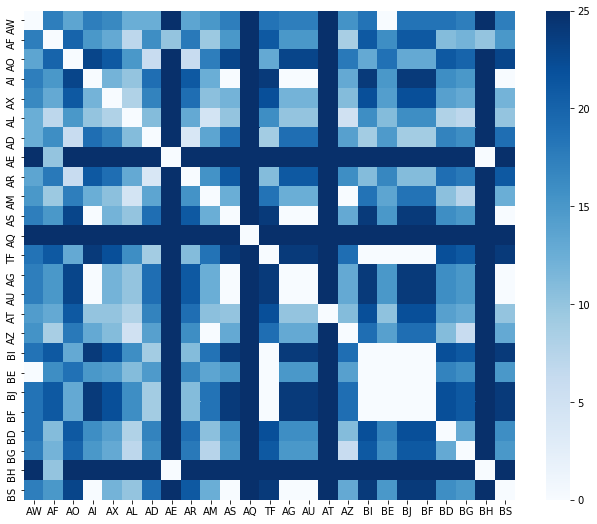

In [6]:
# Heatmap of language distances between countries
plt.figure(figsize=[11,9])
sns.heatmap(country_dist_languages.iloc[:25,:25],cmap="Blues", vmin=0., vmax=25.);

The issue with this type of distance is that it takes discrete values which don't account for the actual distance between the different languages in terms of comprehension, facility to learn the other language etc.. For example, in the cell below we show the case of two pairs of languages, ones that we know are significantly much closer (Italian-Spanish) than the others (English-German), which in fact are very differnet. By using this distance metric, we see that the distance between these languages is the same in this case, while it shouldn't be.

In [7]:
print('Distance between English-German:', dist_languages.loc['English', 'German'])
print('Distance between Italian-Spanish:', dist_languages.loc['Italian', 'Spanish'])

Distance between English-German: 9.0
Distance between Italian-Spanish: 9.0


Results more representative of the reality of the situation could have been obtained had we had not only the phylogenetic links between the languages but the moment that the a new language appeared from a mother language. Incoroporating this time component would have given a more precise approximation, assuming that languages evolve at similar rates and that once the new language has emerged that there is minimal contact / influence from the mother or any sister languages. 

Still we managed to have an algorithm that worked quite well as we can see in the next map where we show the language distances relative to Spain.

### Example 1

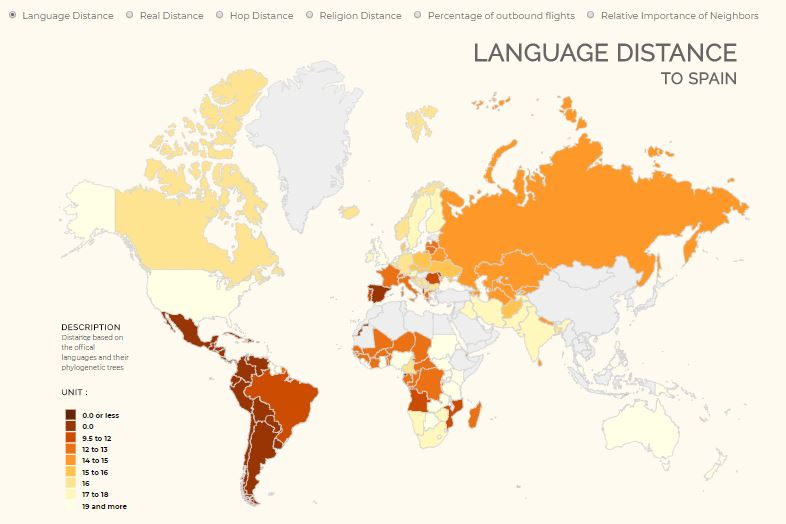

In [8]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "Language distance example 1.jpg"), width=1000)

We can see that in Europe our algorithm displayed correctly the most similar languages relative to Spain (Italian, Portuguese and French) and it also correctly matched all South and Central America as having close similarity.

To play with the interactivity of the map you can visit http://tweet-awareness.eu/ in the section Modelling the reactions, by selecting Language Distance at the top of the map and clicking any country.

### Example 2

We noticed a problem with the language religion distance to Switzerland. It displays that the distance between Switzerland and Germany is 16, which is a lot taking into account that both speak German. 

Because Switzerland has 4 official languages and that Swiss German and German are not identified as the same, the distance between Switzerland and Germany are computed as the average of the distances between Sitzerland's 4 official languages and German. Ideally we would have pondered the computation by the proportion of the population speaking each one of the official languages. Unfortunately we did not have this data at hand.

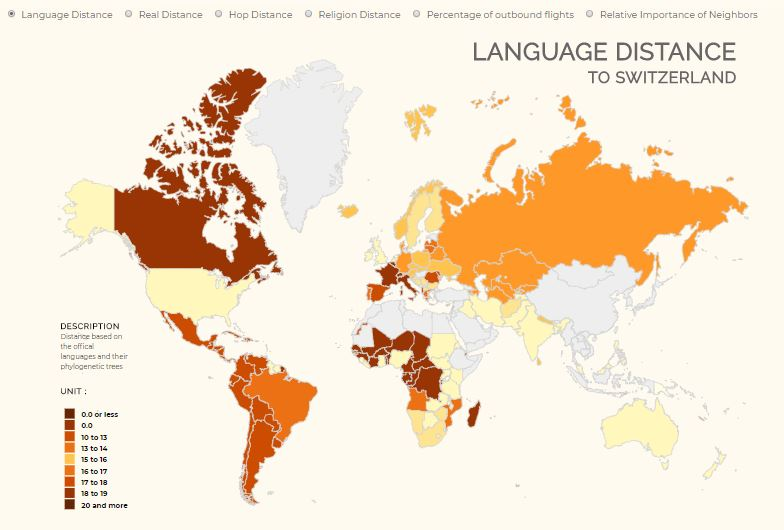

In [9]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "Language distance example 2.jpg"), width=1000)

____

## 3.2. Governments

The type of government is also a good representative of the people's perception to worldwide events. People of different countries with the same government type will be influenced in a similar way. 

After getting the list of all the government types (see "Data enriching.ipynb" for more details on how we got them) we have to convert them to a numeric scale with a meaning.

First, we start by dividing all the government types in three groups and assigning them numerical values -1, 0 and 1. These are the resulting groups:
- Group 1:
    - 'parliamentary democracy'
    - 'parliamentary republic'
    - 'federal republic'
    - 'federation of monarchies'
    - 'semi-presidential republic'
    - 'semi-presidential federation'
- Group 2: 
    - 'non-self-governing overseas territory'
    - 'in transition'
    - 'unknown'
- Group 3: 
    - 'presidential republic'
    - 'presidential democracy'
    - 'monarchy'
    - 'theocratic republic'
    - 'communist state'
    - 'absolute monarchy'

As our criteria to group the government types, we used the variable of the power that the leaders of the government have. Coutries where the leader has a lot of power go in group 3 and will be assigned to the value of 1, the others in group 1 and they will be assigned the value -1. For the non well defined government types, we placed them at the center of the scale with the value of 0.

Here is the actual implementation (full code on "Data enriching.ipynb"):

In [10]:
# Reading the dataframe
data = pd.read_pickle(os.path.join(os.getcwd(), 'DataEnriching', 'data.pickle'))

# Defining the three groups
gov_type_array = [['parliamentary democracy', 'parliamentary republic', 'federal republic', 'federation of monarchies',
                   'semi-presidential republic', 'semi-presidential federation'],
                  ['non-self-governing overseas territory', 'in transition', 'unknown'],
                  ['presidential republic', 'presidential democracy', 'monarchy', 'theocratic republic', 'communist state',
                   'absolute monarchy']]

# Creating the mapping dictionary
mapping_gov_type=dict()
for i, gov_group in enumerate(gov_type_array):
    for gov in gov_group:
        if i==0:
            mapping_gov_type.update({gov: -1})
        elif i==1:
            mapping_gov_type.update({gov: 0})
        else:
            mapping_gov_type.update({gov: 1})

# Mapping gov_type values to their numerical value (1, 0, -1)
data['gov_type_num'] = data.gov_type.map(mapping_gov_type)
data[['gov_type', 'gov_type_num']].head()

,gov_type,gov_type_num
,,
name,,
Aruba,parliamentary democracy,-1.0
Afghanistan,presidential republic,1.0
Angola,presidential republic,1.0
Anguilla,parliamentary democracy,-1.0
Åland Islands,unknown,0.0


In order to compute the distance metric between government types, the numeric government type will be used. The distance metric will be defined by the absolute value of the subtraction between the values of each pair of countries. That way, we end up with a symetric metric with possible values of 0, 1 and 2.

In [11]:
# Reading the dataframe and setting ISO2 as index (as it will be the useful country code)
data = pd.read_pickle(os.path.join(os.getcwd(), 'DataEnriching', 'data.pickle'))
data.reset_index(inplace=True)
data.set_index('ISO2', inplace=True)

In [12]:
# Selecting numeric government type column
gov_type_df = data[['gov_type_num']]

# Creating the matrix with the distances
gov_distance_df = pd.DataFrame(columns=gov_type_df.index.tolist())

for country1, value1 in zip(gov_type_df.index.tolist(), gov_type_df['gov_type_num']):
    row = []
    for country1, value2 in zip(gov_type_df.index.tolist(), gov_type_df['gov_type_num']):
        row.append(abs(value1-value2))
    
    
    dictionary = dict(zip(data.index.tolist(), row))
    gov_distance_df = gov_distance_df.append(dictionary, ignore_index=True)
    
gov_distance_df.index = gov_type_df.index
gov_distance_df.head()

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AW,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AF,2.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0
AO,2.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0
AI,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AX,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


This metric was not used because it is discrete with only 3 levels. This is not sufficient to represent the complexity of this metric which would need to take more and ideally continuous values in order to be representative of the reality. 


____

## 3.3. Distances 

Distance tends to play an important role in determining people's interest regarding a specific event. But there are several types of distances which can be considered when speaking of countries. 

The first and most evident is the **birds-eye-view distance** between the countries. This is computed based on the positions of the center of each country. But this is not enough. Take for example the US and Canada, the distance between the center of thees two countries is much larger than the distance between France and any of its neighboring countries. 

So what else could we consider to have a more representative representation of distance between the different countries? We came up with three other distance metrics which combined would be more complete.


1. **Relative Importance of Neighbors** :  To take into account the fact that two countries can be neighbors and still have a big distance between them we decided to create a metric which would give importance to countries which are direct neighbors. We also wanted to make sure to give each neighbor the importance it is due. For example France has  multiple countries at its border. But that does not mean that each of these countries are of similar importance. That is why we weighted this metric by the size of the countries. Therefore a small neighboring country such as Luxemburg would have a smaller weight than Germany for example.  

2. **Hop Distance** : This second metric accounts not only for direct neighbors but also for the smallest number of countries which would need to be traversed to connect any two countries in the world. 

3. **Flight Routes** : This last metric accounts for movement of populations between the different countries. The assumption is that the existence of flight routes is due to the fact that people exhibit a certain interest for the other country. The more often you visit a place, the more likely you are to be interested in what is going on there. 


These metrics are all constructed in the country distances noteboook in the GeoMetrics folder (https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/GeoMetrics/country_distances.ipynb). Refer to this noteboook for more detail on how the metrics were constructed. 

** Bird's Eye View Distance / Real Distance **

Constructing this mapping was relatively straightforward. Using the position in latitude and longitude of the countries the distance between all countries in computed all the while being carefull with the extreme values of longitude. It is important to consider the shortest path as the earth is round. 

In [13]:
# Reading the dataframe and dropping the level 0 to make the plot nicer
real_distance = pd.read_pickle(os.path.join(os.getcwd(), 'GeoMetrics', 'real_distance.pickle'))
real_distance.columns = real_distance.columns.droplevel(0)

# Factor to change from lat-lon distance to kilometric distance
real_distance = real_distance.multiply(105.)
real_distance.head()

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AW,0.000000,14334.038806,9652.779185,935.045487,10678.745076,9909.158314,8138.336193,13072.388018,4922.530701,12412.041270,...,838.262706,810.318054,18672.969393,13260.569313,11478.743453,11091.934178,12389.281193,10785.899521,10886.421289,11037.285377
AF,14334.038806,0.000000,6831.055006,13546.325435,5525.558163,4799.085850,6741.703234,1492.330392,15262.969894,2224.910111,...,13696.113905,13729.445040,4832.345445,11881.713892,13387.862348,13777.471704,2599.677865,7804.686092,6237.565631,6668.946693
AO,9652.779185,6831.055006,0.000000,9162.720750,7626.166933,5619.707510,6044.571945,5346.242840,8951.827327,6174.946356,...,9312.613256,9340.187375,9851.116687,15596.830207,17356.703266,17762.864221,4234.638414,1826.215349,1235.703241,1441.600673
AI,935.045487,13546.325435,9162.720750,0.000000,9767.195109,9053.324406,7251.723178,12317.305724,5486.947723,11584.831475,...,154.101665,185.796898,17956.332491,14098.867697,12322.159098,11939.900021,11677.487221,10410.679987,10386.824962,10574.855569
AX,10678.745076,5525.558163,7626.166933,9767.195109,0.000000,2007.277498,2674.733481,5215.471271,13238.812485,3377.493221,...,9895.551674,9928.553076,10322.025329,17390.788679,18857.139692,19240.328039,5580.948678,9367.147830,7958.226773,8478.833110


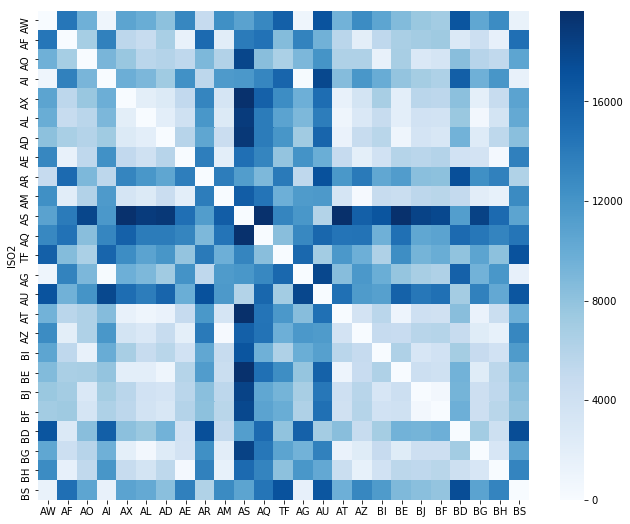

In [14]:
# Heatmap of real distance between countries
plt.figure(figsize=[11,9])
sns.heatmap(real_distance.iloc[:25,:25],cmap="Blues");

Here is an example of the visualization of the real distance metric for the case of France where we can see that the algorithm worked really well.

To play with the interactivity of the map you can visit http://tweet-awareness.eu/ in the section Modelling the reactions, by selecting Real Distance at the top of the map and clicking any country.

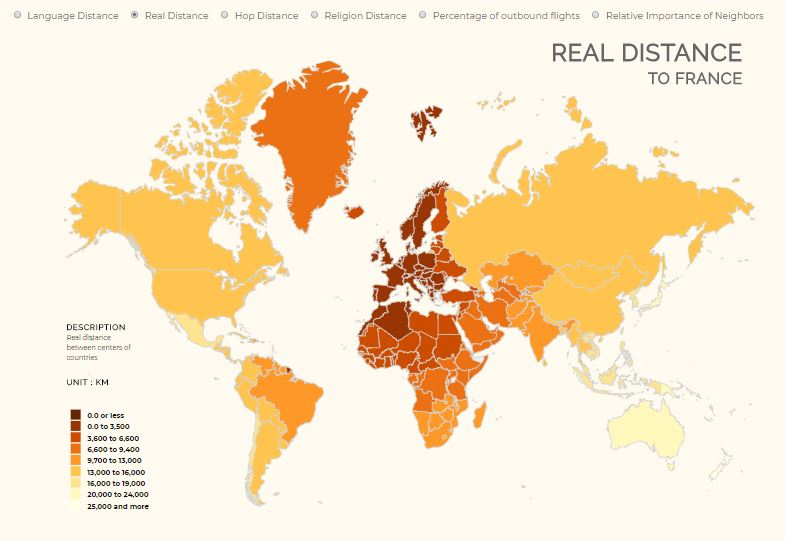

In [15]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "Real distance example.jpg"), width=1000)


** Hop Distance **


For this metric as well as for the following we established an adjacency matrix of the connected countries in term of borders. It is important to note that Islands and certain continents are isolated which means that the resulting graph will not be fully connected. 

This will also be a usefull tool to create a neigborhood influence matrix.
We can visualize the graph using networkx. 

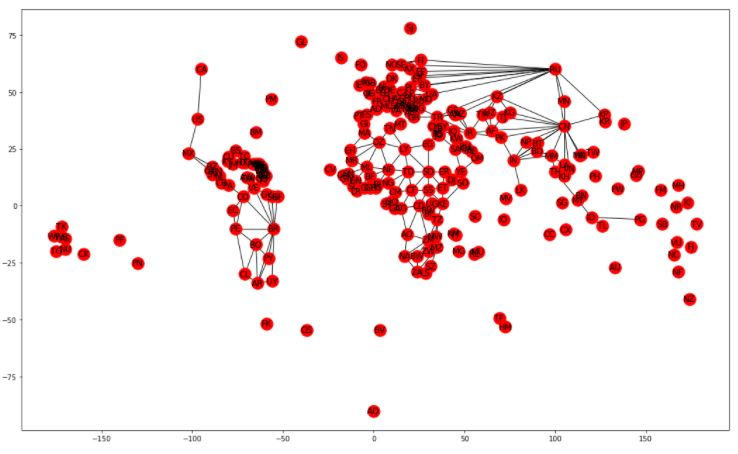

In [16]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "Hop Distance Graph.jpg"), width=1000)

With the obtained graph in networkx we compute the shortest path between all pairs of nodes to obtain what we call the hop matrix between all countries. Countries which are not connected have a hop distance of infinity between them in the final dataframe.

In the next cell we plot the heatmap of the hop distance. We can see that the countries that are not connected (islands) have an infinite distance and are represented with the darkest color on of the scale.

In [17]:
# Reading the dataframe and dropping the level 0 to make the plot nicer
hop_distance = pd.read_pickle(os.path.join(os.getcwd(), 'GeoMetrics', 'hop_distance.pickle'))
hop_distance.columns = hop_distance.columns.droplevel(0)
hop_distance.head()

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AW,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AF,inf,0.000000,9.000000,inf,inf,4.000000,6.000000,4.000000,inf,2.000000,...,inf,inf,2.000000,inf,inf,inf,4.000000,11.000000,9.000000,inf
AO,inf,9.000000,0.000000,inf,inf,9.000000,8.000000,8.000000,inf,8.000000,...,inf,inf,11.000000,inf,inf,inf,8.000000,2.000000,1.000000,inf
AI,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AX,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


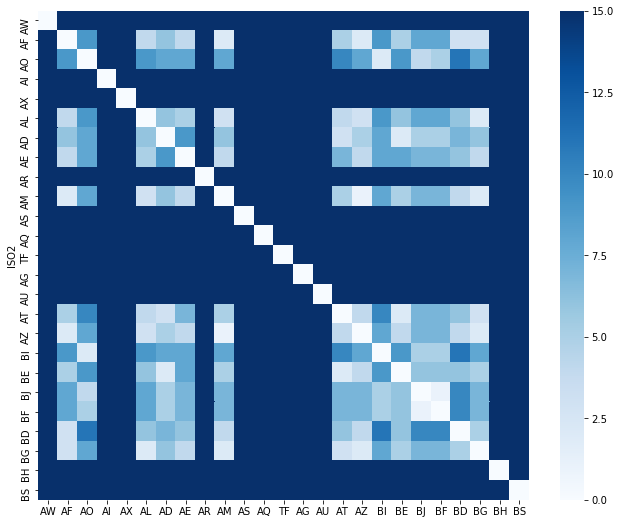

In [18]:
# Heatmap of real distance between countries
plt.figure(figsize=[11,9])
sns.heatmap(hop_distance.iloc[:25,:25],cmap="Blues", vmin=0., vmax=15.);

In [19]:
# Examples of islands with infinite distance
print(hop_distance.loc['MV'].head()) # Maldives
print(hop_distance.loc['CU'].head()) # Cuba

AW    inf
AF    inf
AO    inf
AI    inf
AX    inf
Name: MV, dtype: float64
AW    inf
AF    inf
AO    inf
AI    inf
AX    inf
Name: CU, dtype: float64


In the next cell we visualize the hop distances related to Spain. We can see an example to verify that it works: to go from Spain to Poland we just need to jump three times (France-Germany-Poland).

To play with the interactivity of the map you can visit http://tweet-awareness.eu/ in the section Modelling the reactions, by selecting Hop Distance at the top of the map and clicking any country.

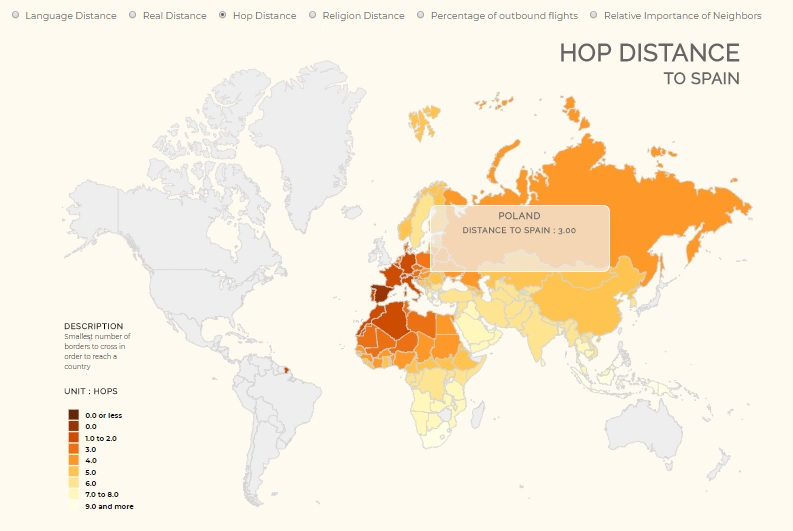

In [20]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "hop distance example.jpg"), width=1000)

** Relative Importance of Neighbors **

The adjacency matrix established previously is then used to create a weighted adjacency matrix where the edges weighted by the size of the neighboring country over the sum of the sizes of all the neighbors. The graph is no longer an undirected graph. 

The following visualization needs an explanation in order to be well interpreted. When you clik on a country (C1 from now on), the countries that are in contac with C1 pop up with some percentages of influence. What do these percentages mean? They have to be interpreted as how many reactions there will be if some event happend in the country that we clicked on, C1.

In the following cell we visualize an easy example. We clik Spain and we are interested in knowing the reaction levels of the surrounding countries. As explained in more detail in country_distances.ipynb, this metric was computed by comparing the areas of the neighbor countries. For Portugal, the only country in contact is Spain, so when we click in Spain it will display a 100% at Portugal. This is because if we compare the area of Spain with the area of the sum of all the countries in contact with Portugal (in this case just Spain) we get that value. For France, which has higher total area of neighbors counties, the relative area of Spain becomes smaller and thus the percentage of importance is lower (41%) and for Morroco even lower (16%).

In conclusion, when we click on a country C1, the given percentages have to be seen as what importance will give the given country to an event happening in C1.

To play with the interactivity of the map you can visit http://tweet-awareness.eu/ in the section Modelling the reactions, by selecting Relative Importance for Neighbors at the top of the map and clicking any country.

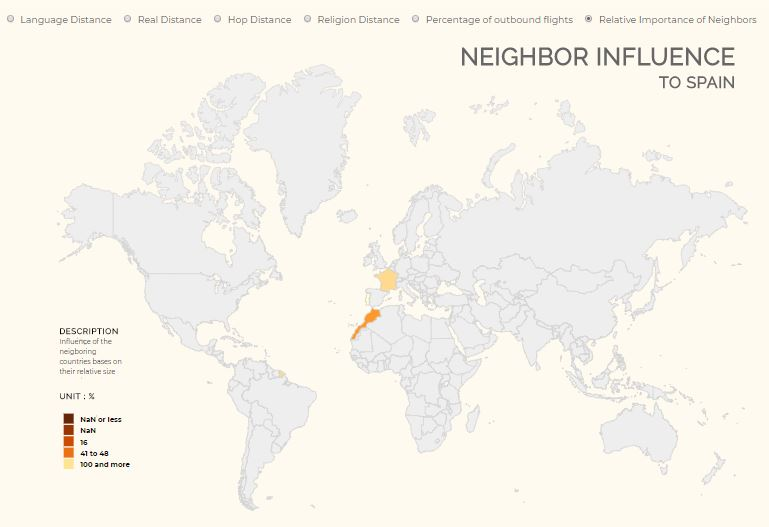

In [21]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "neighbor influence example.jpg"), width=1000)


** Flight Routes **

Given a dataset of 59036 routes between 3209 airports on 531 airlines in the world as of January 2012. In addition the that we are able so associate all the Airports to their country thanks to a second dataset. Both were taken from https://openflights.org/data.html

Once that was done, we associated all the routes with the departure and arrival countries. That way were able to determine for each country the proportion of flights to all other countries. 

In [22]:
# Reading the dataframe and dropping the level 0 to make the plot nicer
flight_routes = pd.read_pickle(os.path.join(os.getcwd(), 'GeoMetrics', 'flight_routes.pickle'))
flight_routes.columns = flight_routes.columns.droplevel(0)
flight_routes.head()

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AW,inf,inf,inf,inf,inf,inf,6.81818,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AF,inf,inf,inf,inf,inf,inf,inf,24.1379,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AO,inf,inf,inf,inf,inf,inf,inf,6.89655,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,10.3448,inf,3.44828
AI,inf,inf,inf,inf,inf,inf,40,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AX,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In the same way as before the graph is a directed graph. Here we can visualize the nodes at the positions of the countries.

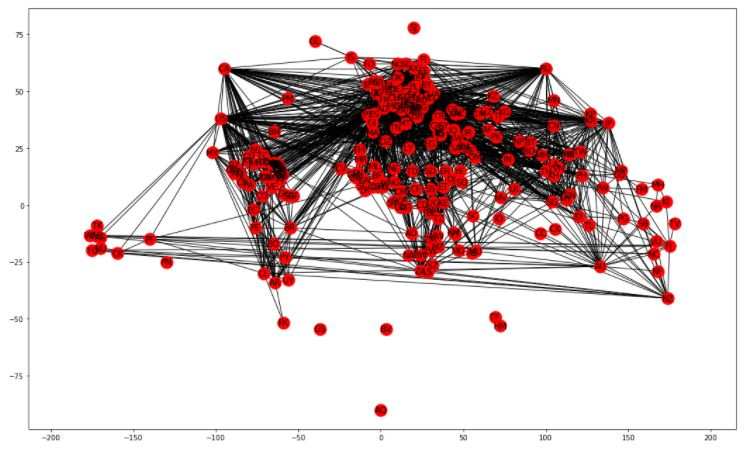

In [23]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "flight routes graph.jpg"), width=1000)

For an example, here we visualized the flights coming to Russia. This map has to be interpreted as the previous one.
As we clicked in Russia, the given percentages in the other countries are representative of the amount of flights that go to Russia in that countries. The more flights to Russia, we assumed that the more interest a surrounding country would have related to Russia. In this case we can see that Uzbekistain is really interested in Russia, with a percentage of awareness of 68%.

To play with the interactivity of the map you can visit http://tweet-awareness.eu/ in the section Modelling the reactions, by selecting Percentage of outbound flights at the top of the map and clicking any countryo

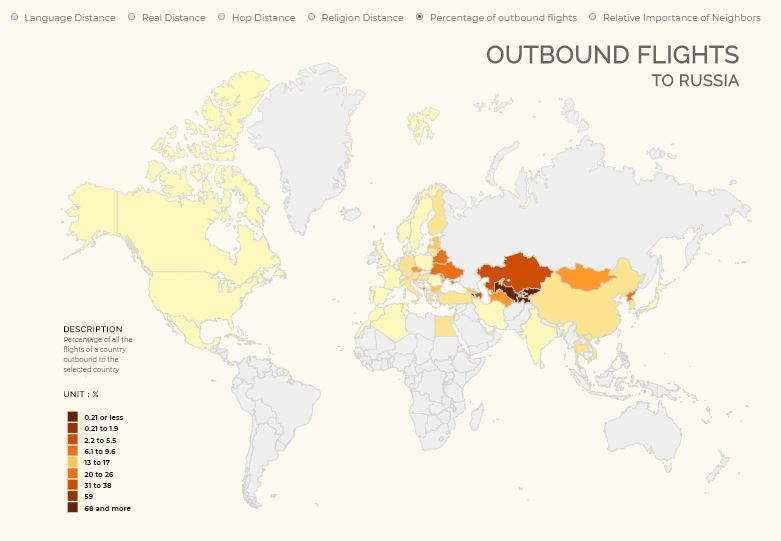

In [24]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "flight routes example.jpg"), width=1000)

____

## 3.4. Religions 

Religion, like government, affects the way of thinking of the people. Religion bonds between countries will definitely have an impact on the awareness of events that happen in countries with the same religions.

Here we can see the religion data that we were originally using in Milestone 2:

In [25]:
rel_df_milestone2 = pd.read_pickle(os.path.join(os.getcwd(), 'DataEnriching', 'Pickles for Milestone 3', 'final_rel_df.pickle'))
rel_df_milestone2.head()

name     religion                              \
                           Christianism Judaism     Islam  Buddhism   
ISO2                                                                  
AF             Afghanistan       0.0003     0.0  0.995600  0.000099   
AO                  Angola       0.8912     0.0  0.010399  0.000099   
AL                 Albania       0.2144     0.0  0.630000  0.000000   
AD                 Andorra       0.9070     0.0  0.008999  0.000000   
AE    United Arab Emirates       0.0714     0.0  0.674800  0.003500   

                                                                              \
     Zoroastrian   Hindu      Sikh Shinto    Baha'i Taoism Jain Confucianism   
ISO2                                                                           
AF      0.000099  0.0003  0.000099    0.0  0.000099    0.0  0.0          0.0   
AO      0.000000  0.0000  0.000000    0.0  0.000099    0.0  0.0          0.0   
AL      0.000000  0.0000  0.000000    0.0  0.002200    0.0  0.0          0.0   
AD      0.000000  0.0035  0.000000    0.0  0.000000    0.0  0.0          0.0   
AE      0.000000  0.2225  0.000000    0.0  0.009999    0.0  0.0          0.0   

                                                                          
     Syncretic religions Animist religions Non-religious Other religions  
ISO2                                                                      
AF                   0.0          0.000099      0.002000          0.0014  
AO                   0.0          0.075899      0.017899          0.0044  
AL                   0.0          0.000000      0.150700          0.0027  
AD                   0.0          0.000000      0.079600          0.0009  
AE                   0.0          0.000000      0.013599          0.0041

Unfortunately, there were too many countries for which the religion information was not complete. That is why we went back to the factbook which was more complete. 

### Methodology
From now on, we will explain how we took the data from the factbook dataset.

We could extract the religions from Dataset 2, but we had to do some cleaning to have the desired format of the data. First we needed to know which where the religions that were in the dataset, so we created an array containing the unique names of the religions that appeared througouth each country. Once we know all the religions, we created the religions dataframe, containing the percentage of every religion in every country. Finally, we grouped the small religions in 10 broader categories of religions.

As said, we start by creating the unique religions array. Here is a sample of part of the array:

In [26]:
#unique_religions[:20]
['Adventist', 'Animist', 'Armenian Apostolic', 'Assembly of God', 'Awakening Churches/Christian Revival', 'Badimo',
 "Baha'i", 'Baptist', 'Bektashi', 'Buddhism', 'Buddhist', 'Bukot nan Jesus', 'Calvinist', 'Cao Dai', 'Catholic', 'Christian',
 'Christianity','Church of England', 'Church of Ireland', 'Church of Norway']

['Adventist',
 'Animist',
 'Armenian Apostolic',
 'Assembly of God',
 'Awakening Churches/Christian Revival',
 'Badimo',
 "Baha'i",
 'Baptist',
 'Bektashi',
 'Buddhism',
 'Buddhist',
 'Bukot nan Jesus',
 'Calvinist',
 'Cao Dai',
 'Catholic',
 'Christian',
 'Christianity',
 'Church of England',
 'Church of Ireland',
 'Church of Norway']

Now that we have all possible religions in one array, we will create the dataframe (rel_df), with all religions as columns, and the country as the index. The cell values will represent the percentage of the religion in the country.

Some of the countries had bad formated data to be extracted (i.e. percentages given by ranges like 10-30%, some countries didn't have the percentages, etc). We manually added the rows of the countries that had issues. For the countries that didn't have percentages, we searched on Wikipedia for the percentages and we also added them manually.

To create the rel_df dataframe, the rows were appended into an initial empty dataframe. The rows were created by looping through all unique_religions and checking if the country in particular had that religion. If it had it, we inserted the percentage. If it didn't have it, we inserted the value zero in that religion column.

Here is what the rel_df looks like, after dropping the smallest religions (columns) that didn't have more than 10% in any country:

In [27]:
rel_df = pd.read_pickle(os.path.join(os.getcwd(), 'DataEnriching', 'rel_df.pickle'))
rel_df.set_index('ISO2', inplace=True)
rel_df.head()

,Armenian Apostolic,Assembly of God,Awakening Churches/Christian Revival,Buddhism,Buddhist,Calvinist,Catholic,Christian,Church of Norway,Congregational Christian Church,...,none,none or other,other,other Christian,other and unspecified,other or none,other or unspecified,unaffiliated,unaffiliated or other,unspecified
ISO2,,,,,,,,,,,,,,,,,,,,,
DZ,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,...,0.000,0.0,0.010,0.000,0.0,0.0,0.0,0.0,0.0,0.000
AO,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,...,0.123,0.0,0.086,0.000,0.0,0.0,0.0,0.0,0.0,0.000
BW,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.791,0.0,0.0,...,0.152,0.0,0.014,0.000,0.0,0.0,0.0,0.0,0.0,0.003
BJ,0.0,0.0,0.0,0.0,0.0,0.0,0.255,0.000,0.0,0.0,...,0.058,0.0,0.026,0.095,0.0,0.0,0.0,0.0,0.0,0.000
BI,0.0,0.0,0.0,0.0,0.0,0.0,0.621,0.000,0.0,0.0,...,0.000,0.0,0.036,0.000,0.0,0.0,0.0,0.0,0.0,0.079


### Grouping religions under broader categories
We grouped the religions in broader categories by adding the percentages. We had to dropp some columns that didn't provide any information about the religious similarity between two countries (i.e unspecified, none or other, other, etc).

In [28]:
# Here are the broader categories that we came up with
protestants = ['Calvinist', 'Church of Norway', 'Congregational Christian Church', 'Ekalesia Niue', 'Evangelical', 
               'Evangelical Lutheran', 'Evangelical Lutheran Church of Iceland', 'Evangelical or Protestant', 'Lutheran',
               'Protestant', 'Protestant and other', 'Seventh-Day Adventist', 'non-Catholic Christians', 'Armenian Apostolic', 
               'Assembly of God', 'Christian', 'Kimbanguist', 'Mormon', 'Zionist Christian', 'nondenominational']
               
catholic = ['Awakening Churches/Christian Revival', 'Catholic', 'Roman Catholic', 'nominally Roman Catholic']
orthodox = ['Eastern Orthodox', 'Ethiopian Orthodox', 'Greek Orthodox', 'Macedonian Orthodox', 'Orthodox', 'Orthodox Christian',
                'Russian Orthodox', 'Serbian Orthodox']
buddhism = ['Buddhism', 'Buddhist', 'Lamaistic Buddhist']
hindu = ['Hindu', 'Indian- and Nepalese-influenced Hinduism']
jewish = ['Jewish', 'Zionist', ]
muslim = ['Muslim', 'Sunni Muslim']
oriental = ['Shintoism', 'Taoist', 'mixture of Buddhist and Taoist']
other = ['Vodoun', 'eclectic mixture of local religions', 'folk religion', 'indigenous beliefs']
animist = ['animist', 'animist or no religion']
atheist = ['atheist or agnostic', 'no religion', 'non-believer/agnostic', 'non-believers']
unaffiliated = ['unaffiliated', 'unaffiliated or other']

# Those religions will be dropped
dropped_cols = ['Kempsville Presbyterian Church', 'none', 'none or other', 'other',
                'other Christian', 'other and unspecified', 'other or none', 'other or unspecified', 'unspecified',
                'atheist and agnostic']

# Arrays needed to run next cell
final_categories = [protestants, catholic, orthodox, buddhism, hindu, jewish, muslim, oriental, other, animist,
                   atheist, unaffiliated]
final_categories_names = ['protestants', 'catholic', 'orthodox', 'buddhism', 'hindu', 'jewish', 'muslim', 
                           'oriental', 'other', 'animist', 'atheist', 'unaffiliated']

The function that unifies the small religions to broader religion groups, and the resulting dataframe are the following:

In [29]:
def generate_categories_df(dataframe):
    df = pd.DataFrame()
    for category, category_name in zip(final_categories, final_categories_names):
        df[category_name] = dataframe[category].sum(axis=1)
    return df

categorized_df = generate_categories_df(rel_df)
categorized_df.head()

,protestants,catholic,orthodox,buddhism,hindu,jewish,muslim,oriental,other,animist,atheist,unaffiliated
ISO2,,,,,,,,,,,,
DZ,0.000,0.000,0.0,0.0,0.0,0.0,0.990,0.0,0.000,0.0,0.0,0.0
AO,0.381,0.411,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0
BW,0.791,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0
BJ,0.135,0.255,0.0,0.0,0.0,0.0,0.277,0.0,0.116,0.0,0.0,0.0
BI,0.239,0.621,0.0,0.0,0.0,0.0,0.025,0.0,0.000,0.0,0.0,0.0


To compute the distances, the euclidean dot product was applied using the following function, that returns the matrix with the distances between each pair of countries.

In [30]:
rel_distances = spatial.distance.squareform(spatial.distance.pdist(categorized_df,'euclidean'))

In [31]:
# Converting it to a dataframe
rel_distance_df = pd.DataFrame(rel_distances, index=rel_df.index.tolist(), columns=rel_df.index.tolist())
rel_distance_df.head()

,DZ,AO,BW,BJ,BI,TD,CG,CD,CM,KM,...,UY,VE,AF,BD,BT,LK,IN,IO,MV,NP
DZ,0.000000,1.137621,1.267194,0.777866,1.172172,0.476006,1.138065,1.064002,0.910891,0.022361,...,1.379166,0.007000,0.140716,1.263309,1.144487,1.164662,0.990000,0.990000,1.250672,0.026000
AO,1.137621,0.000000,0.580535,0.418374,0.254733,0.664930,0.232011,0.156467,0.247931,1.121803,...,0.657056,1.143718,1.057338,0.964330,0.886425,0.976756,0.560430,0.560430,0.987226,1.115069
BW,1.267194,0.580535,0.000000,0.765210,0.831246,0.879648,0.810948,0.707871,0.687791,1.259556,...,1.231276,1.272670,1.195643,1.114240,1.071210,1.116598,0.791000,0.791000,1.129041,1.246987
BJ,0.777866,0.418374,0.765210,0.000000,0.470884,0.338941,0.418418,0.363366,0.232897,0.762309,...,0.774877,0.784287,0.695487,0.888417,0.781279,0.863744,0.416455,0.416455,0.903593,0.754105
BI,1.172172,0.254733,0.831246,0.470884,0.000000,0.714326,0.078549,0.154877,0.306165,1.153407,...,0.404360,1.177941,1.096685,1.029192,0.940524,1.040572,0.665873,0.665873,1.051521,1.150862


Here is an example for the religion distance. We clicked in France. As we used euclidean dot product to compute the distance between each pair of countries, similar countries in this map regarding religions will have high values and thus, they will be displayed in darker colors. Different countries will have low values and lighter colors.

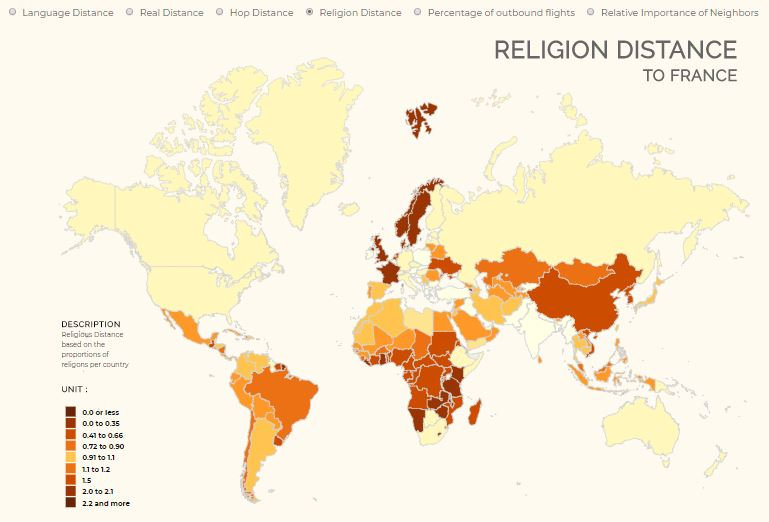

In [32]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "religion distance good example.jpg"), width=1000)

To compute the last map, we had to solve also the issues with the lack of data of some countries. In the categorized_df dataframe there are countries that have null values in every religion. This represents a big issue because when computing the distance between countries, these countries will have distance zero not for their religious proximity, but because we lacked the data. We managed to find the percentages of the main religions in most of the important countries by searching in Wikipedia. Here is an example of some manually inserted values:

In [33]:
# We found the percentages on wikipedia by doing the search on google: percentages of main religions [country]
data.set_value('Greenland', ('religion', 'christianity'), 0.96);
data.set_value('Madagascar', ('religion', 'atheist'), 0.84);
data.set_value('North Korea', ('religion', 'atheist'), 0.643);
data.set_value('Palestine', ('religion', 'muslim'), 0.85);
data.set_value('Palestine', ('religion', 'jewish'), 0.12);
data.set_value('Sudan', ('religion', 'muslim'), 0.97);

____

## 3.5. Population, Area, GDP, Internet users, population in poverty, unemployment rate

Countries can be characterized by general attributes such as population, size, gross domestic product (GDP), poverty line, internet users and so forth. These metrics are interesting because they are in direct link to the number of tweets in a conutry and can be used as normalizing factors. 
         
As we announced previously, by using the factbook dataset for Milestone 3 we were able to extract more features than in Milestone 2. These features are straight forward to extract from Dataset 2 (see "Data enriching.ipynb"). From the data.pickle file we can extract them directly. The result is the following:

In [34]:
other_features = pd.read_pickle(os.path.join(os.getcwd(), 'DataEnriching', 'data.pickle'))
cols = [('POP',''),('area',''),('gdp',''),('gdp_capita',''),('Internet users',''),('pop_pov',''),('unemployment','')]
other_features = other_features[cols]
other_features.head()

,POP,area,gdp,gdp_capita,Internet users,pop_pov,unemployment
,,,,,,,
name,,,,,,,
Aruba,113648.0,180.0,2.516000e+09,25300.0,99000.0,NaN,0.069
Afghanistan,33332025.0,652230.0,1.840000e+10,2000.0,2690000.0,0.358,0.350
Angola,20172332.0,1246700.0,9.194000e+10,6800.0,2434000.0,0.405,NaN
Anguilla,16752.0,91.0,1.754000e+08,12200.0,12000.0,0.230,0.080
Åland Islands,NaN,1580.0,NaN,NaN,NaN,NaN,NaN


____

##  3.6. Estimating Number of Active Tweeters 

As will be explained in the next portion of the notebook it is important to have a normalizing factor to account for differences in twitter activity between the different country. The ideal thing would have been to have the number of active tweeters per country. A second best would have been to simply have the number of tweeters per country. Unfortunately none of this is available to the public. That is why it was important to create our own estimation of these values to generate the model. 

We had at our disposal the number of tweets worldwide for 8 different events. We used this to compute the average number of tweets per country and used it as a baseline. We were careful to compute the average of tweets for a given country only using the data when there was no event in the given country. In clearer terms we did not take the number of tweets in France during Charlie Hebdo to compute the average number of tweets. We relied on the 7 other events. In the same fashion we did not consider the tweets for france during the event in Belgium as the countries are sufficiently close to generate larger than normal reactions. The inverse was also done for Belgium.  This implies that we compute the average number of tweets (baseline) using only 6 events for France and Belgium versus 7 for the others. 


The code used to compute the baseline number of tweets over a week called all_tweets can be found at the start of the Correlations and Linear Regression Model notebook. Here we show a modified excerpt as well as the difference when computing the mean without the values in the countries where the event happened. 


In [35]:
import os
events = [x for x in os.listdir('../../Project Data/Tweets/') if "DS_Store" not in x]

for ignore in [False, True]:
    
    all_tweets = list()
    for event in events:
        all_tweets.append(pickle.load(open('../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb')))

    if ignore:
        print()
        print("Ignoring number of tweets for countries in which the event occurred")
        # Setting values to nan if the event occured in the country
        for idx, country in enumerate(["BE", "FR", "TR", "LB", "NG", "NG", "US", "PK"]):
            if country== "BE":
                all_tweets[idx].loc["FR",:] = np.nan
            if country== "FR":
                all_tweets[idx].loc["BE",:] = np.nan
            if country == "US":
                all_tweets[idx].loc["BE",:] = np.nan
                all_tweets[idx].loc["FR",:] = np.nan
            all_tweets[idx].loc[country,:] = np.nan
    else :
        print("Computing baseline using all data")
    all_tweets = pd.concat(all_tweets, axis=1).mean(axis=1, skipna = True)
    print("United States : ", int(all_tweets["US"]))
    print("France : ", int(all_tweets["FR"]))
    print("Belgium : ", int(all_tweets["BE"]))
    print("Pakistan : ", int(all_tweets["PK"]))
    print("Turkey : ", int(all_tweets["TR"]))
    print("Nigeria : ", int(all_tweets["NG"]))
    print("Lebanon : ", int(all_tweets["BE"]))
        

Computing baseline using all data
United States :  107640
France :  72476
Belgium :  8659
Pakistan :  8898
Turkey :  5078
Nigeria :  5933
Lebanon :  8659

Ignoring number of tweets for countries in which the event occurred
United States :  49126
France :  2084
Belgium :  306
Pakistan :  5966
Turkey :  4929
Nigeria :  4761
Lebanon :  306


We can clearly see that there is a difference in terms of baseline tweets for all these countries, the most flagrant being the factor 35 and 28 of difference for France and Belgium respectively. This also shows the level of reaction which occurred in both countries. 

____
____
____

# 4. Constructing the Awareness Model 

Given all of these metrics we wanted to creat a graph linking all countries. The more countries have attributes in common, the more likely they are to react to what is going on. But how do we quantify that two countries share things in common? 

We first observed whether any variables correlated highly with the measured reactions. Unfortunately as we will show, it was not the case for any of the events. This can be seen in the [Correlations and Linear Regression Model notebook](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/Correlations%20and%20Linear%20Regression%20Model.ipynb)

Our original idea was to construct a graph linking the different countries. We wanted to use what we saw in recommender systems and topic detection would better be able to select features which best link the countries together. The issue with this method is that it is difficult to determine why the outputs were not optimal. This can be seen in the [Matrix Factorisation - LDA Model](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/Correlations%20and%20Linear%20Regression%20Model.ipynb) notebook  


That is why we attempted two alternative methods :
- Using random search to find the optimal weights combining our features to construct a final graph upon which we could do diffusion and compare the output to the reactions for the different events. See the [Weighting Metrics and Graph Diffusion](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/Weighting%20Metrics%20and%20Graph%20Diffusion.ipynb) notebook. 

- Using support vector regression which is a non linear regression method to predict the reaction directly [SVR Model](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/SVR%20Model.ipynb) 
       
The issue with both of these methods is that we have to predict the outputfor 250 countries with a very limited dataset (8 events). We would have required a much larger dataset consisting of at least 1000 events in order to properly train and test the model.  


## 4.1. Correlations

The first thing we wanted to do was to verify whether any of the our metrics highly correlated with the observed reactions. That is what we did in the Correlations and Linear Regression Model notebook [Correlations and Linear Regression Model notebook](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/Correlations%20and%20Linear%20Regression%20Model.ipynb)

Originally we had hoped that a subset of features would correlate with the reaction for a given number of events. Unfortunately this was not the case for any of the observed events. 

Loading the important dataframes

In [36]:
features_df = pd.read_pickle(os.path.join("AwarenessModel","correlation_features.pkl"))
all_tweets = pd.read_pickle(os.path.join("AwarenessModel","all_tweets.pickle"))


data = pickle.load(open('DataEnriching/data.pickle','rb'))
data = data.reset_index()
data = data.set_index("ISO2")

# Keep only relevant fields 
data = data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov', 'region']]

lang_feature_df = pd.read_pickle('LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('GeoMetrics/flight_routes.pickle')
hop_distance_df = pd.read_pickle('GeoMetrics/hop_distance.pickle')
neighbor_influence_df = pd.read_pickle('GeoMetrics/neighbor_influence_v2.pickle')
dist_feature_df = pd.read_pickle('GeoMetrics/real_distance.pickle')
religion_and_more_df = pd.read_pickle('DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# Load the number of internet users
internet_users = pickle.load(open('AwarenessModel/internet_users.pickle','rb'))
internet_users.set_index("ISO2", inplace = True)
internet_users.replace("unknown", np.nan, inplace = True)
internet_users["Internet users"] = internet_users["Internet users"].astype(np.float)
med = np.median([x for x in internet_users["Internet users"].tolist() if not np.isnan(x)])
internet_users = internet_users["Internet users"].apply(lambda x: x if not(np.isnan(x)) else med)


Here are the set of functions used to process a given event and plot the correlations as well as a linear regression model.

In [37]:
def load_tweets(event, country_code):
    plt.figure(figsize = (15,10))
    # Loading the Number of tweets of the event in turkey per country
    summary_tweets = pickle.load(open('../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb'))
    #plot = sns.barplot(summary_tweets.index,summary_tweets.text)
    return summary_tweets


def event_specific_features(country_code, summary_tweets):
    # Create the dataframe for the given country
    country_features_df = pd.concat([lang_feature_df.loc[:,("language_dist",country_code)],
                           fligh_routes_df.loc[:,("flight_routes",country_code)],
                           hop_distance_df.loc[:,("hop_distance",country_code)],
                           neighbor_influence_df.loc[:,("neighbor_influence",country_code)],
                           dist_feature_df.loc[:,("real_distance",country_code)], 
                           summary_tweets.loc[:,"text"],
                           data.loc[:,["area", 'gdp', 'gdp_capita', "POP", "2016_gdp_total", "region"]],
                           features_df.loc[:,("Normalized internet users")],
                           features_df.loc[:,("Internet users")]],axis=1)
    #features_df.sort_index(axis=1,inplace=True)

    # Rename the columns
    country_features_df.columns = ['language_dist', 'flight_routes', 'hop_distance', 'neighbor_influence',\
                                   'real_distance', 'text', 'POP', 'area', 'gdp', 'gdp_capita',\
                                    'region', 'Normalized internet users', 'Internet users']
    
    # Change the type of the given columns from object to float
    country_features_df.flight_routes = country_features_df.flight_routes.astype(np.float)
    country_features_df.neighbor_influence = country_features_df.neighbor_influence.astype(np.float)
    
    #country_features_df["text"] = np.log(country_features_df["text"]+1)
    
    country_features_df["Normalized Tweets"] = (country_features_df["text"]-all_tweets) / (all_tweets+1)


    # Remove the information pretaining to the concerned country
    country_features_df.drop([country_code], inplace = True)
    #country_features_df.drop(["BE", "FR"], inplace = True)
    return country_features_df

# Plot correlations between the different metrics and the 
# normalized number of tweets. Compute the regression + R squared metric

def plot_correlations_with_regression(country_features_df):
    fig = plt.figure(figsize = (15,20))

    y_all = country_features_df.loc[:,'Normalized Tweets'].tolist()

    # Compute and plot the correlations for the first columns
    for idx, column in enumerate(country_features_df.columns):
        if idx<9:
            # Create the plot
            ax = plt.subplot(len(country_features_df.columns)//3+1, 3, idx+1)
            
            # Get the x and y values if x is not infinite or nan
            
            x_all = country_features_df.loc[:,column].tolist()
            x = list()
            y = list()

            for i in range(len(x_all)):
                if (not np.isnan(x_all[i]) and not np.isinf(x_all[i])):
                    x.append(x_all[i])
                    y.append(y_all[i])            

            # Plot the original data
            ax.plot(x, y, 'o', label='original data')
            
            # Compute the linear regression 
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
            # Plot the regression 
            ax.plot(np.array(x), intercept + slope*np.array(x), '--r', label='fitted line')
            ax.legend()
            ax.set_xlabel(column)
            ax.set_ylabel("Normalized number of tweets")
            plt.title("{} : r^2 {:.3f}".format(column, r_value**2) )
    fig.tight_layout()


def analyse_event(event_name, country_code, for_region = False):
    
    summary_tweets = load_tweets(event_name, country_code)
    
    # Compute the features for a specific event
    country_features_df = event_specific_features(country_code,summary_tweets)
    
    # Keep countries for which we have the real distance metric (i.e. for which we have all information)
    country_features_df = country_features_df.loc[~ country_features_df["real_distance"].isnull(),:]
    
    # If we only want to analyze for the corresponding region
    if for_region:
        # Extract the region
        region  = data.loc[country_code, "region"][0]
        country_features_df = country_features_df.loc[country_features_df["region"] == region,:]
    
    # Remove small countries from the model
    country_features_df = country_features_df.loc[country_features_df["POP"]>100000,:]
    country_features_df = country_features_df.loc[country_features_df["area"]>1000,:]
        
    # Compute and plot the correlations
    sns.heatmap(abs(country_features_df.corr("spearman")[["text", "Normalized Tweets"]]),annot=True)
    plot_correlations_with_regression(country_features_df)

Here we plot the analysis of the different events : 
- correlation between the raw number of tweets (called text) as well as the normalized number of tweets (by the estimated twitter baseline activity). 
- Linear regression for each of these metrics to see if they can be used to predict the output normalized number of tweets. 

One interesting observation to be made is that there are certain factors such as the GDP, population, number of internet users which exhibit relatively high correlations when observing the raw number of tweets. However this correlation disappears after normalization. 

This shows us that these parameters have a direct influence on the baseline twitter activity of each country. 


Remark : It is important to observe both the correlation factor and the regression!

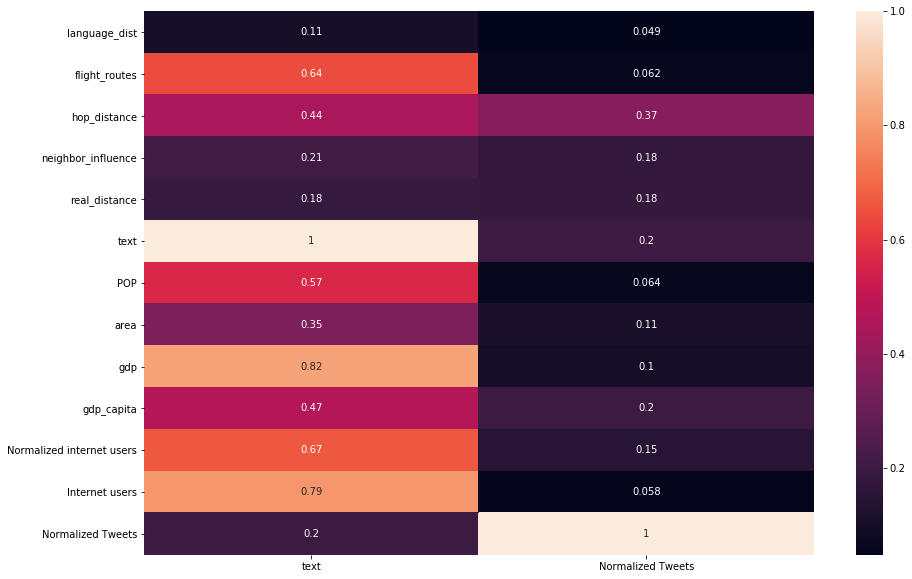

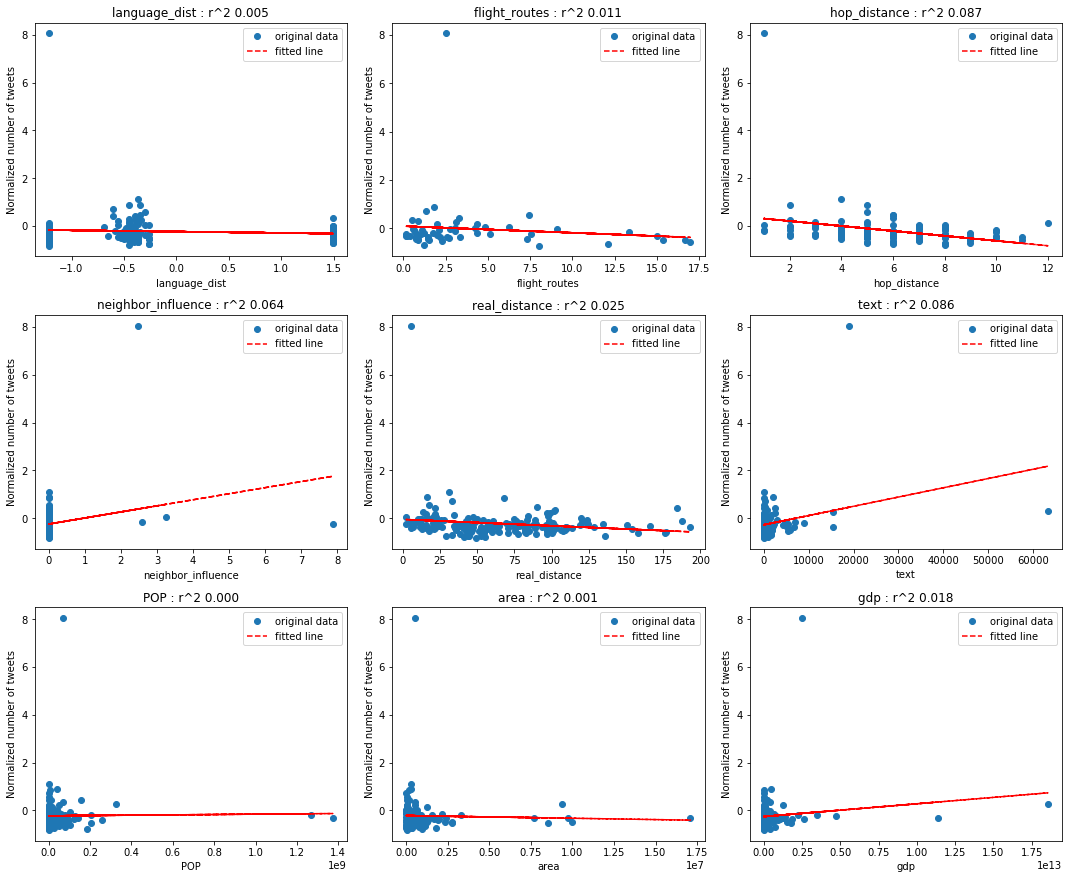

In [38]:
analyse_event("Bruxelles", "BE")

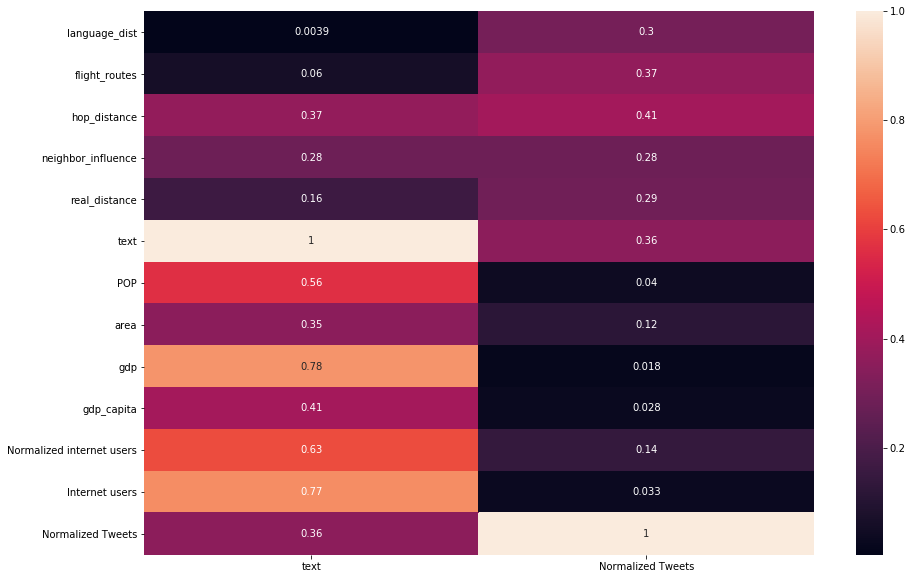

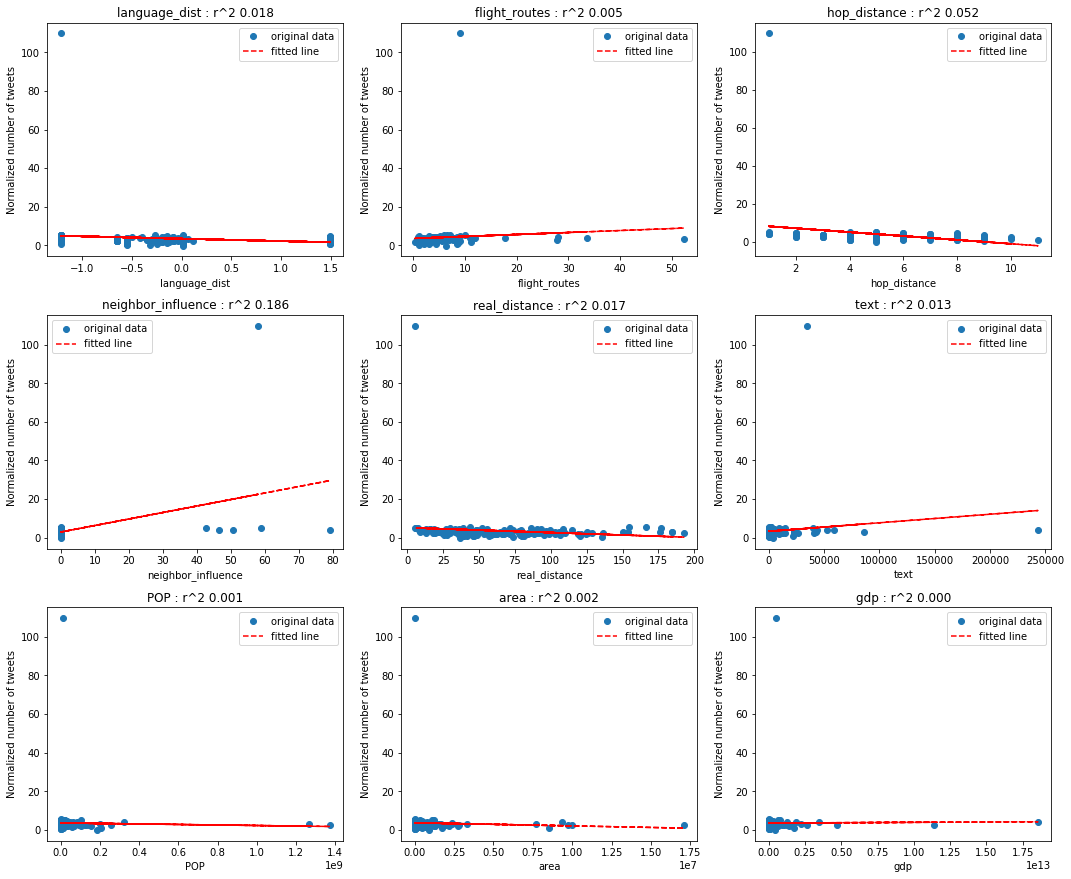

In [39]:
analyse_event("Charlie-Hebdo", "FR")

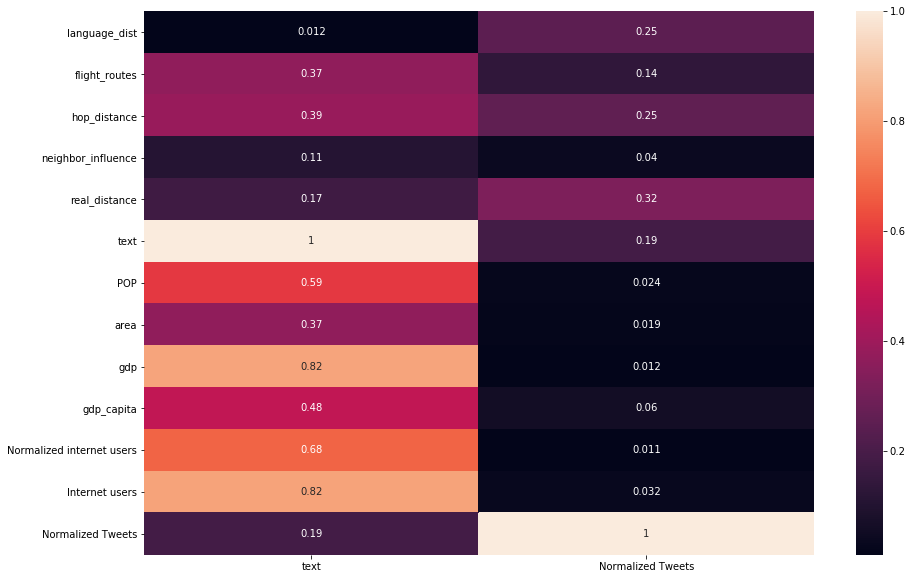

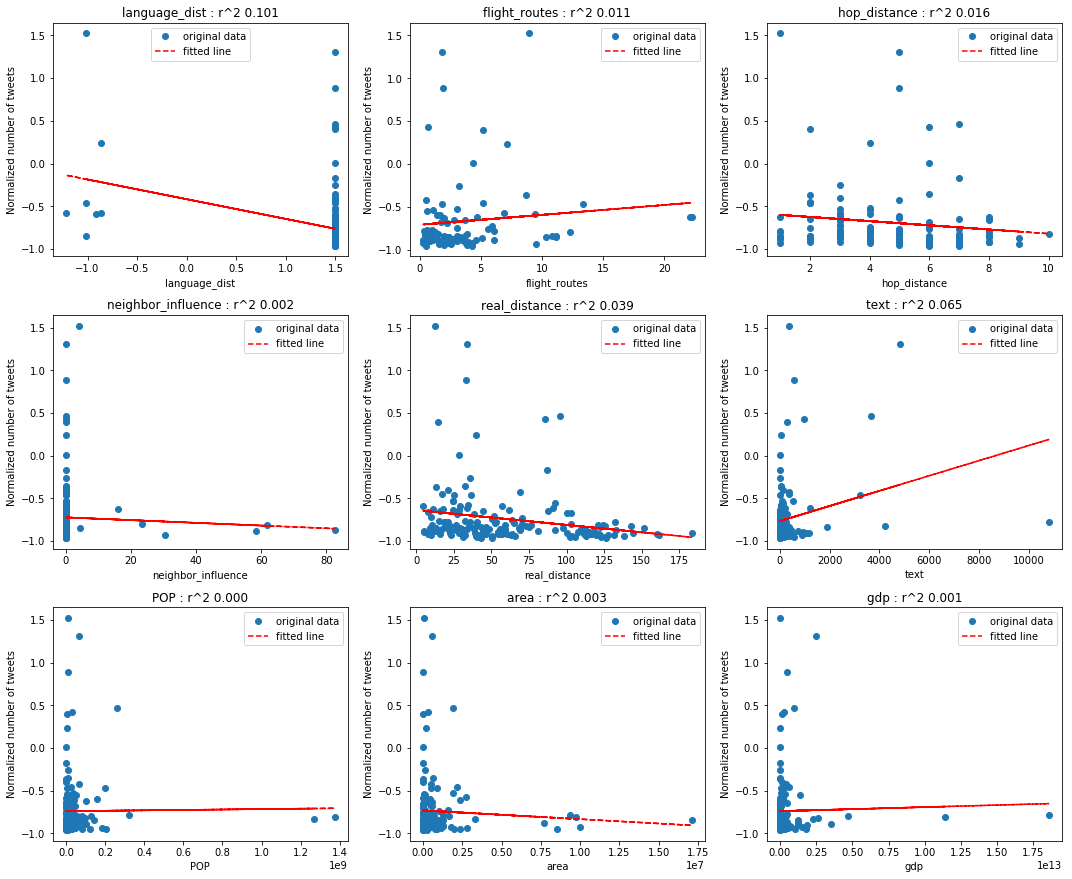

In [40]:
analyse_event("Istanbul", "TR")

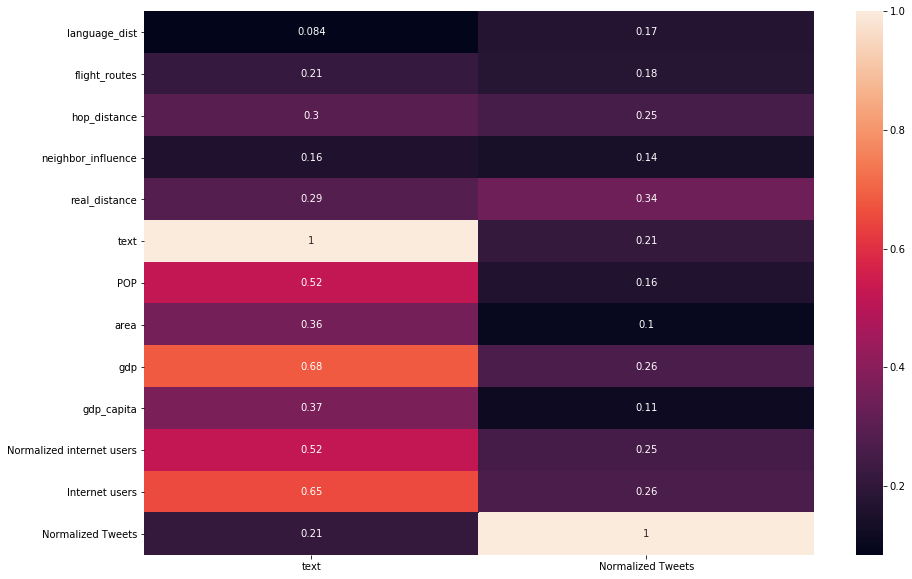

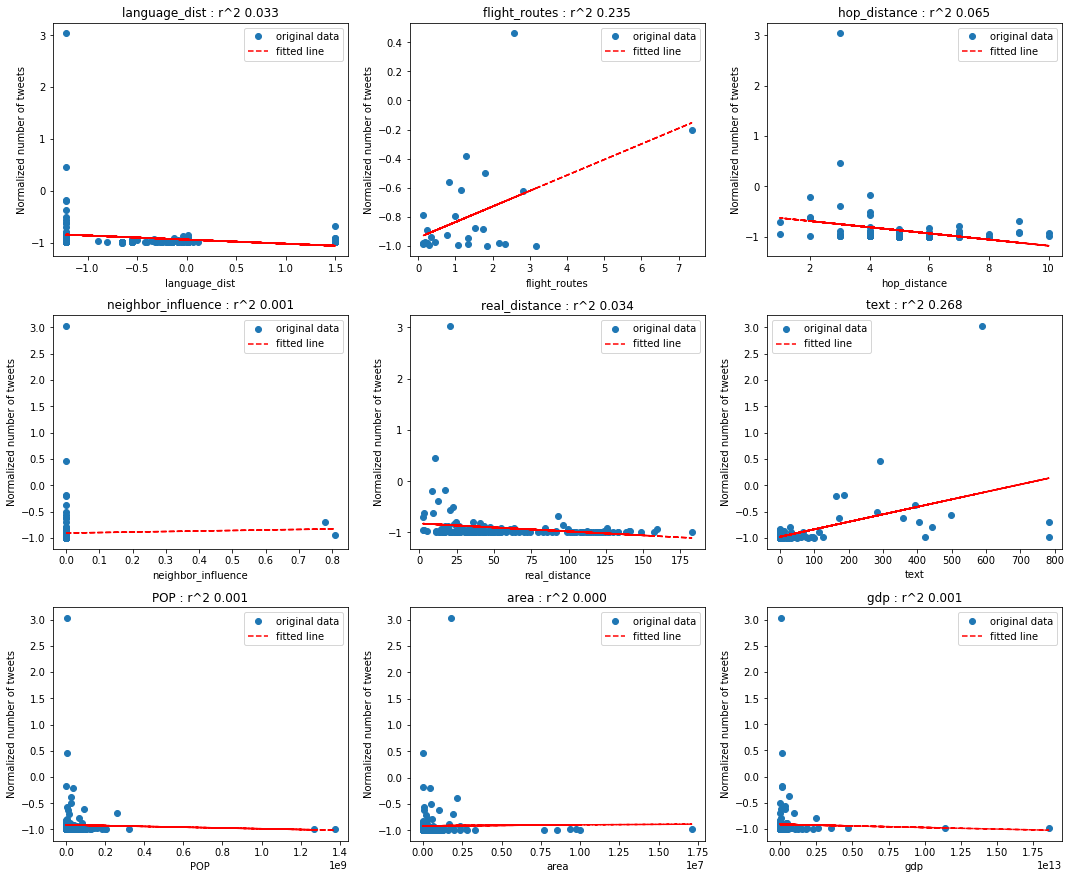

In [41]:
analyse_event("Lebanon", "LB")

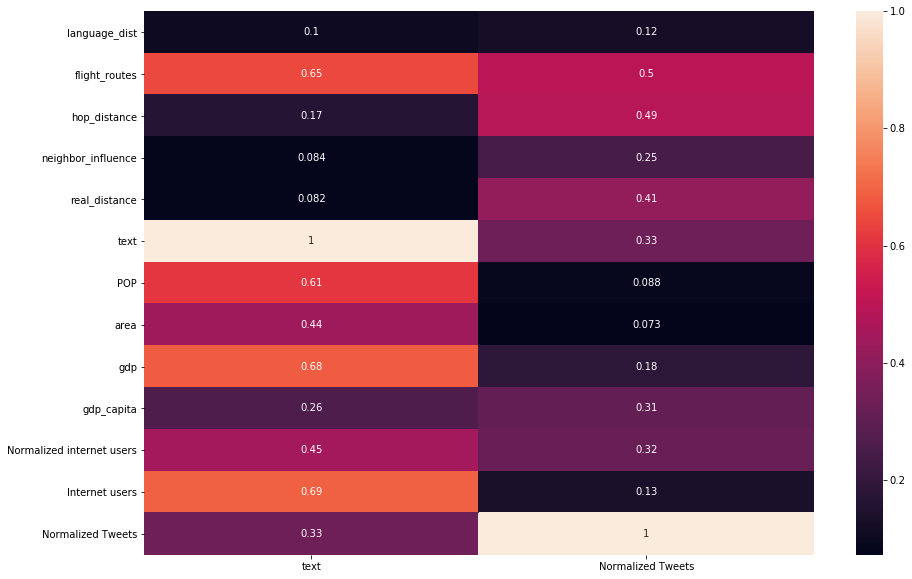

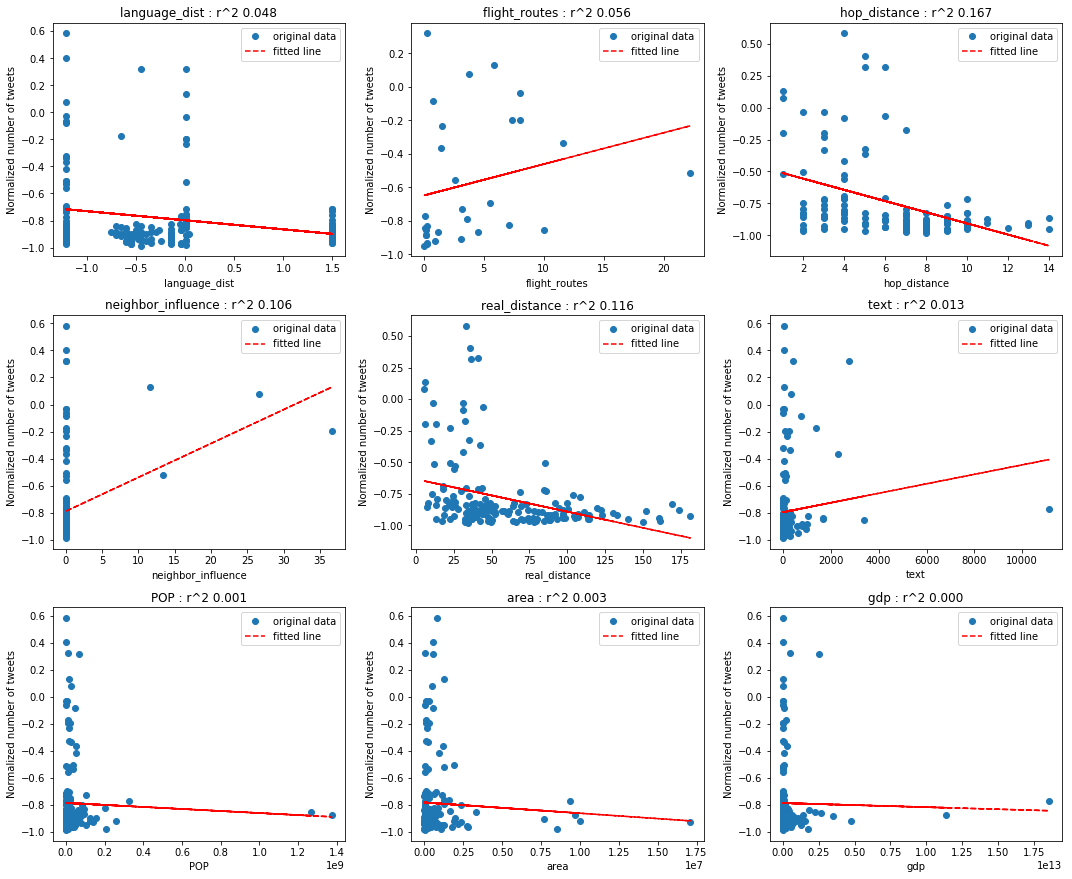

In [42]:
analyse_event("Nigeria_2015", "NG")

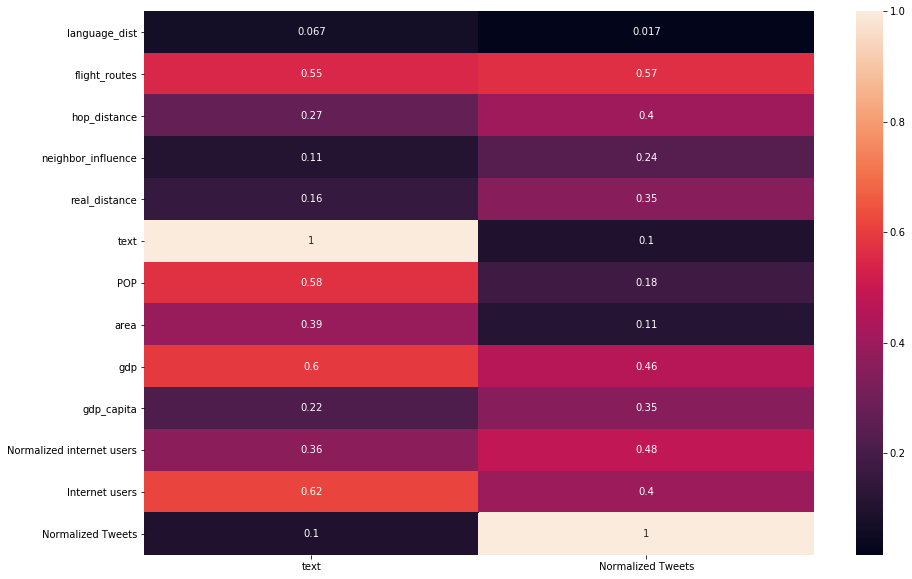

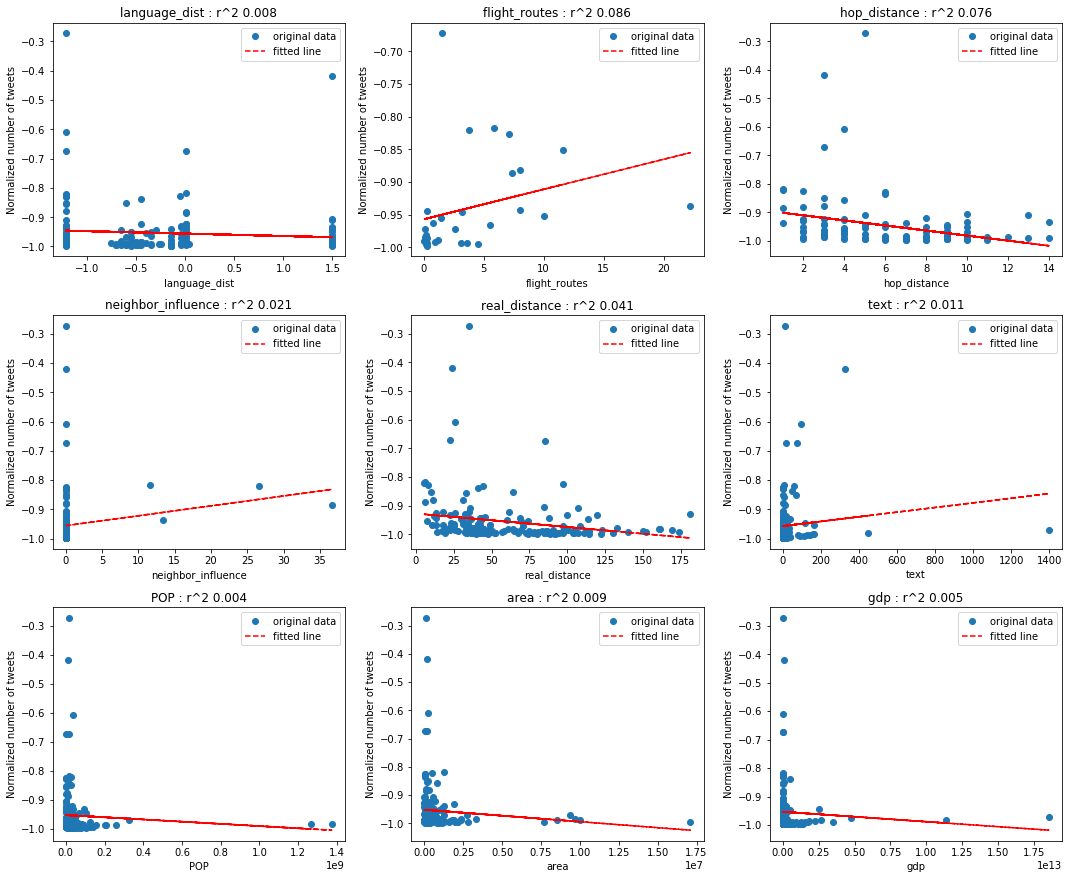

In [43]:
analyse_event("Nigeria_2016", "NG")

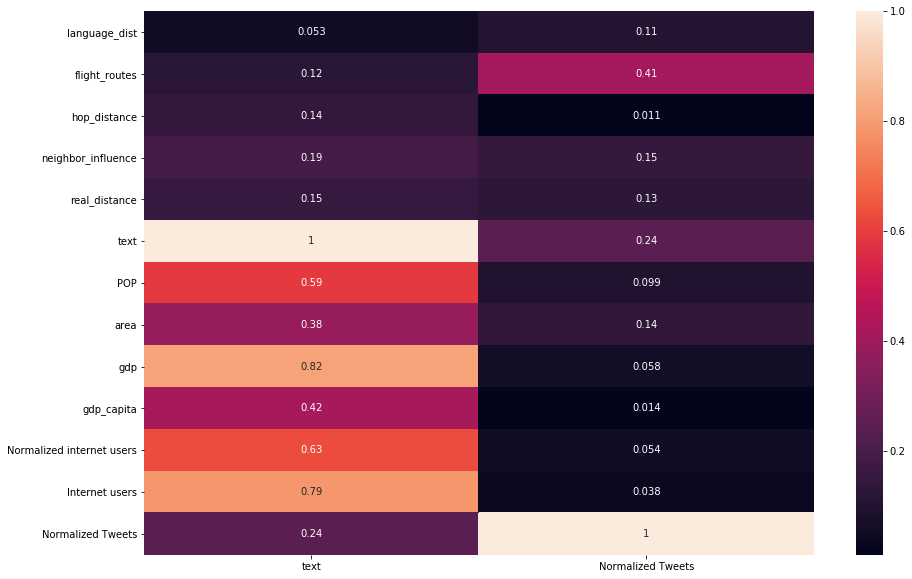

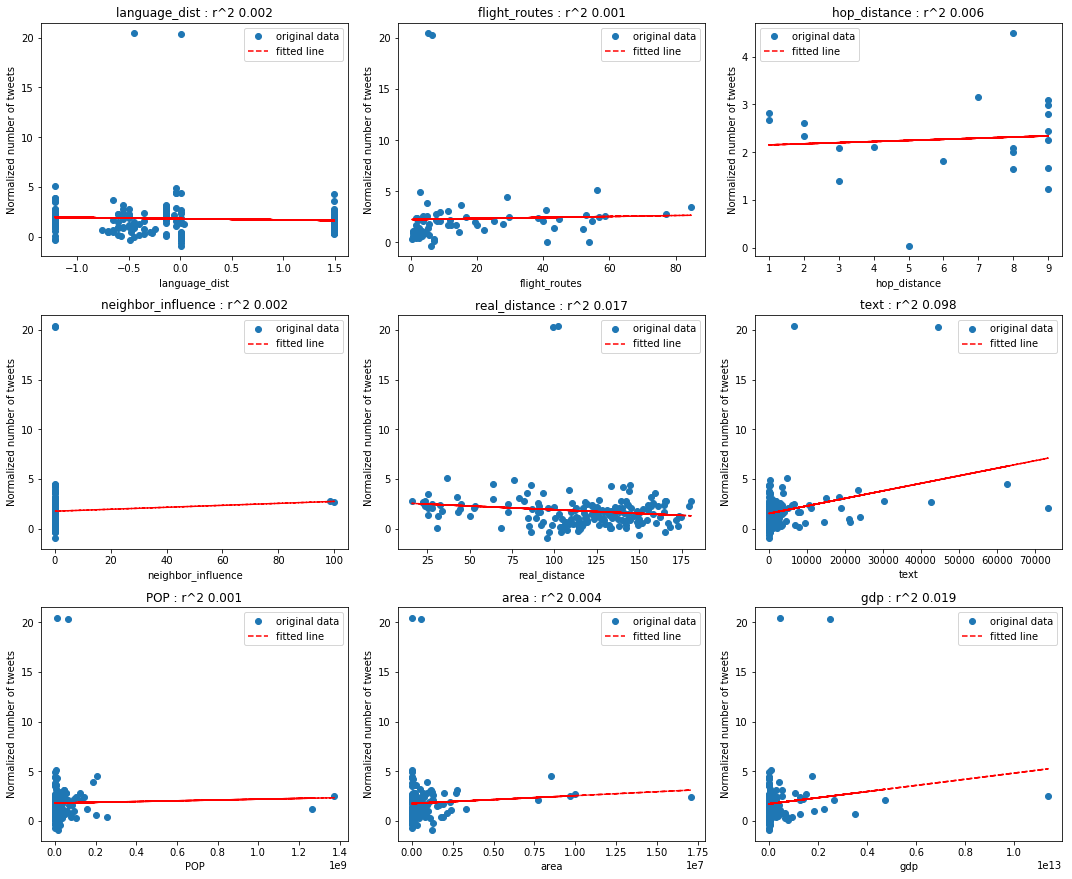

In [44]:
analyse_event("Orlando", "US")

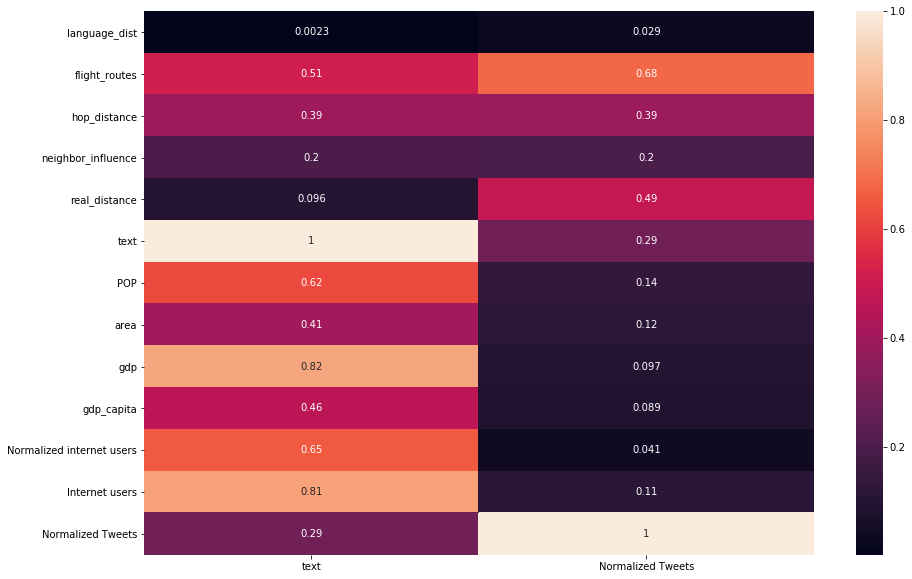

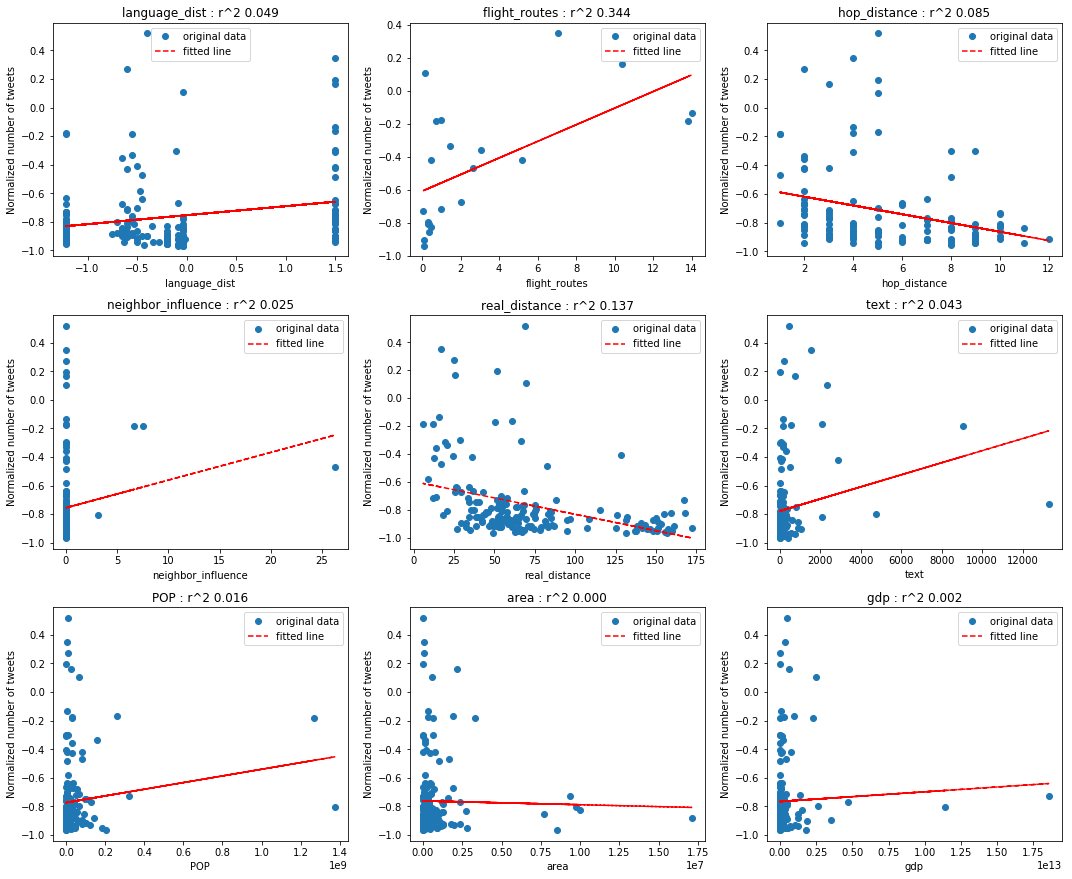

In [45]:
analyse_event("Pakistan", "PK")

Unfortunately, there are no factors which correlate highly and the R squared regression parameters is consistently low, regardless of the event. Often there are quite a large number of outlyers which are most likely due in part to the normalizing factor which is based on an estiamted baseline activity and may be quite far off from the truth. 


We attempted to see whether limiting our analysis to Europe for Charlie Hebdo and Brussels would improve the output but unfortunately that was not the case. 

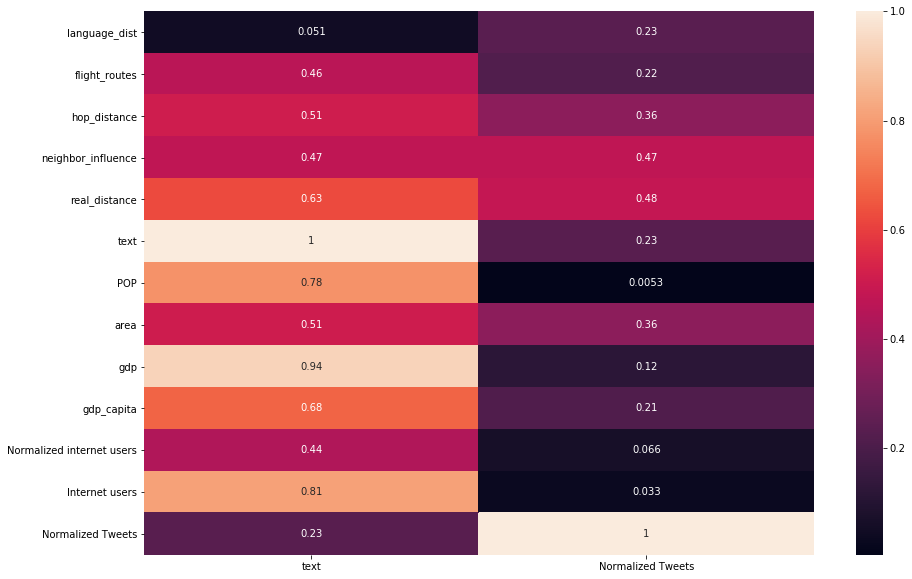

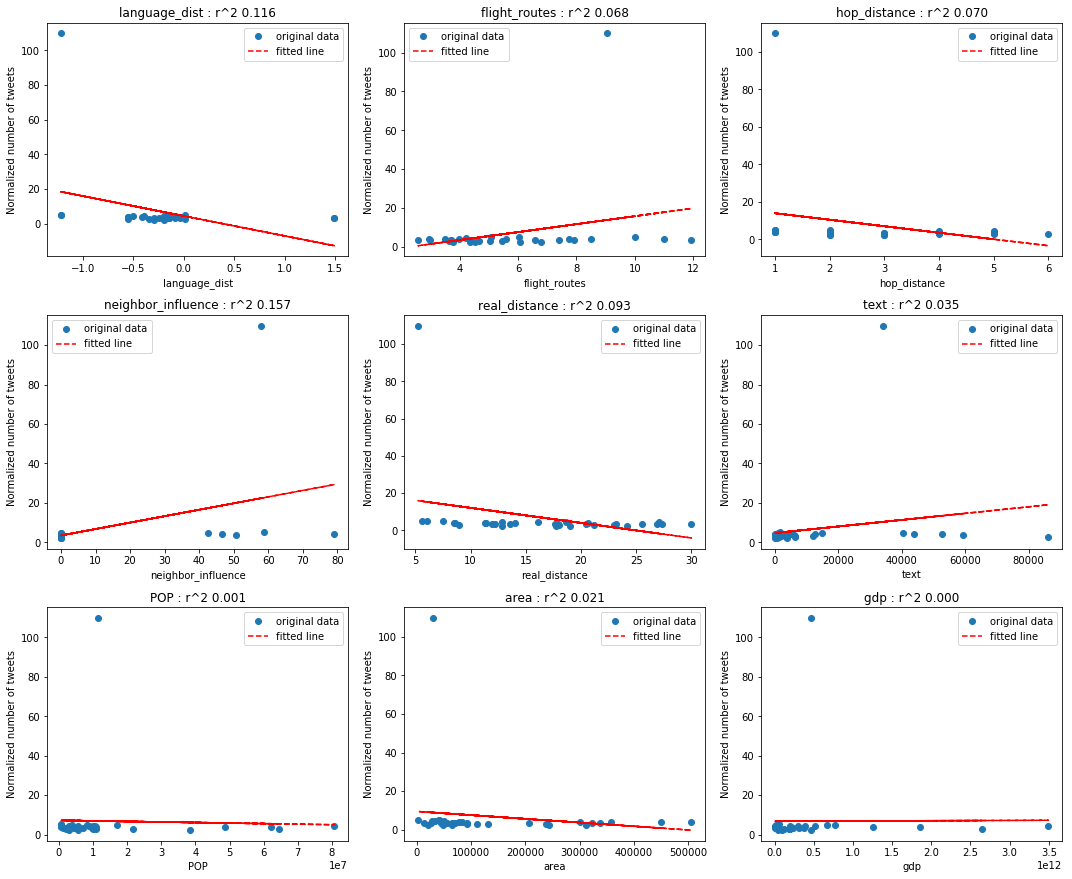

In [46]:
analyse_event("Charlie-Hebdo", "FR", for_region = True)

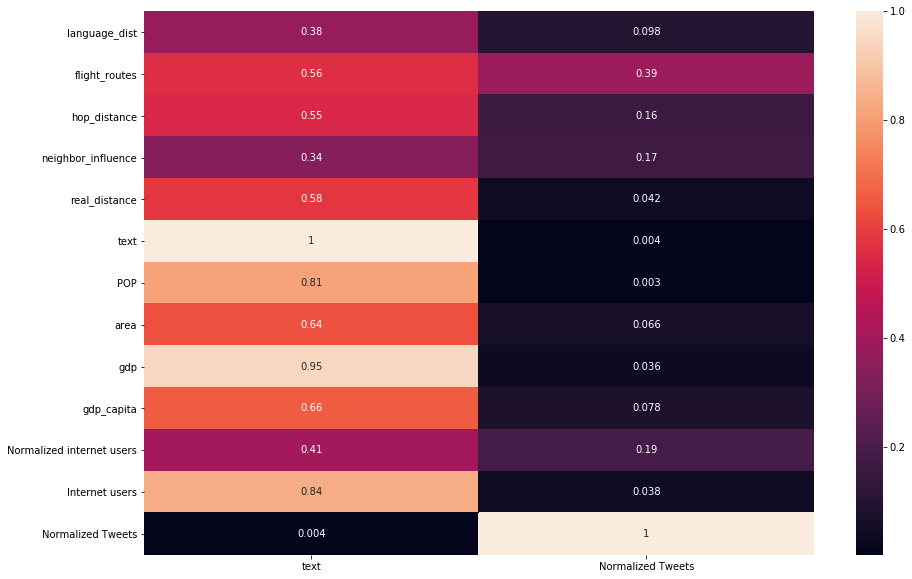

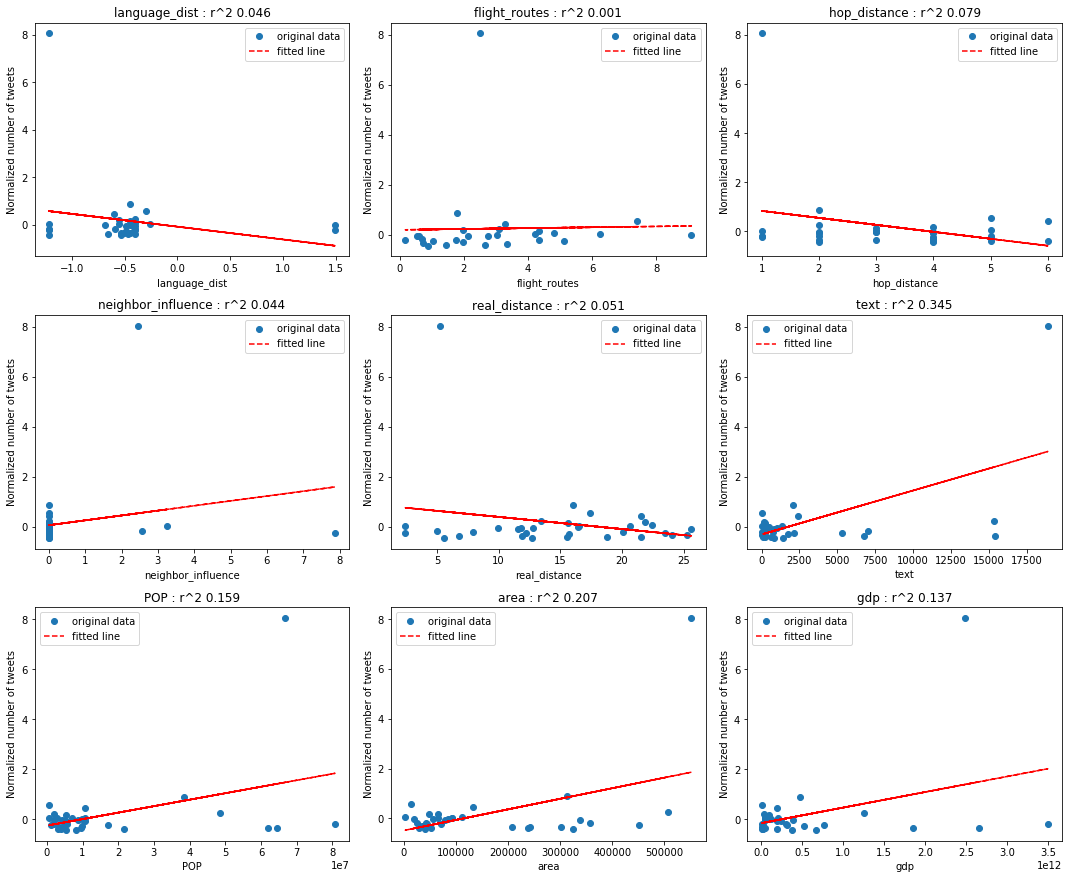

In [47]:
analyse_event("Bruxelles", "BE",for_region = True)


The results vary little compared to what we had previously. This is not surprising as visually, even without knowledge of the interactions, simply observing what is going on around Europe we do not see the trends that we would expect in the number of tweets (refer to the interactive map on the tweet-awareness.eu website)

**TODO  : input a screenshot for charlie hebdo and brussels and explain what we would have expected to see**


____


## 4.2. Formatting and Standardizing the data

For the matrix factorization and the SVR it was first important to standardize the different features before combining them into one big feature vector. This was done for all the different metrics and the additional information for each of the countries. This was done at the start of the [SVR Model](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/SVR%20Model.ipynb) 
 notebook. The resulting dataframe is then exported under **all_features_pos.pickle** and **all_features_pos.pickle** (the latter to have only positive values for the matrix factorization)

____

## 4.3. Matrix Factorization Methods : LDA

As mentioned previously, we hoped that using topic detection methods would offer a good method to find optimal combinations of features which would link the countries together. Given a matrix of countries x topics we would have been able to compute the distance between the different vectors to construct our graph. Given the graph we could then use diffusion from a starting node and heat equations to see how the reaction would spread and then compare that to the outputs obtained for the events which were acquired. 


For details on how the matrix factorization was done, refer to the [Matrix Factorisation - LDA Model](https://github.com/LailaHms/ADA2017_Homeworks/blob/master/Project/AwarenessModel/Correlations%20and%20Linear%20Regression%20Model.ipynb) noteboook.

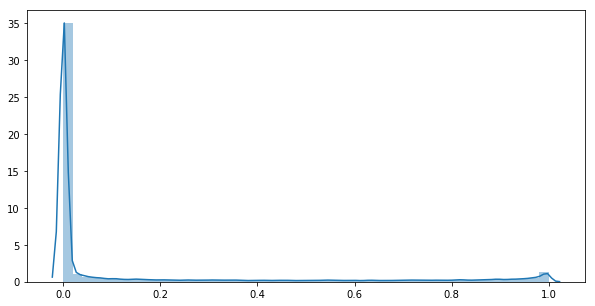

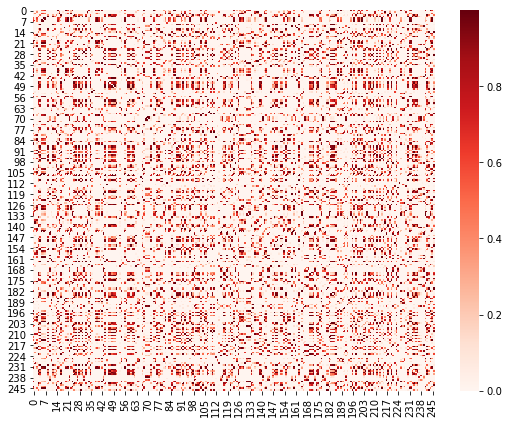

In [48]:
W = pickle.load(open('AwarenessModel/LDA_weights.pickle','rb'))

distances = spatial.distance.squareform(spatial.distance.pdist(W)) # W
#plt.figure(figsize=[9,7])
#sns.heatmap(distances)

kernel_width = np.mean(distances)- np.std(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :

plt.figure(figsize=[10,5])
sns.distplot(weights.flatten())
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")


We can see that the matrix is relatively sparse with a limited number of countries with weights which are close to 1. 

In [49]:
# Get the position of the nodes
c_data = pickle.load(open('DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)

countries = c_data.index.tolist()

weights_df = pd.DataFrame(weights,columns=countries,index=countries)
weights_df.head()

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000e+00,3.043151e-03,1.223436e-01,1.451202e-15,3.555541e-20,5.567480e-01,6.029323e-01,7.026129e-01,2.000984e-73,5.141192e-21,...,2.054763e-28,8.113274e-32,3.390407e-49,1.209515e-38,7.874332e-01,7.651899e-16,1.475598e-11,9.486568e-01,6.340498e-01,1.398921e-11
Afghanistan,3.043151e-03,0.000000e+00,3.995670e-01,7.359640e-06,1.063328e-08,6.746845e-02,5.634584e-02,3.734571e-02,6.871530e-49,3.060130e-09,...,3.097230e-14,1.212876e-16,1.266861e-29,1.268122e-21,2.277138e-04,5.044750e-06,1.242137e-03,9.558626e-04,4.975274e-02,1.208258e-03
Angola,1.223436e-01,3.995670e-01,0.000000e+00,4.057964e-09,1.157764e-12,6.261871e-01,5.799166e-01,4.811186e-01,4.760805e-58,2.533734e-13,...,2.835809e-19,4.457274e-22,8.282559e-37,8.589268e-28,2.335280e-02,2.505856e-09,3.497984e-06,5.965547e-02,5.489332e-01,3.367950e-06
Anguilla,1.451202e-15,7.359640e-06,4.057964e-09,0.000000e+00,4.881615e-01,6.204924e-12,3.575453e-12,1.058550e-12,1.415264e-22,3.754357e-01,...,1.028991e-02,1.067307e-03,2.128440e-10,4.829733e-06,3.767032e-18,9.970348e-01,4.844904e-01,9.402171e-17,2.459738e-12,4.889012e-01
Åland Islands,3.555541e-20,1.063328e-08,1.157764e-12,4.881615e-01,0.000000e+00,5.556535e-16,2.922138e-16,7.093669e-17,1.139034e-17,9.797702e-01,...,1.881550e-01,4.374316e-02,3.074396e-07,8.828863e-04,4.032796e-23,5.337726e-01,5.593788e-02,1.561488e-21,1.890421e-16,5.695995e-02


Checking to see the closest countries to Germany to see if the output is coherent

In [50]:
country = 'Germany'
weights_df[country].loc[weights_df[country] >= 0.9].sort_values(ascending = False)

Denmark                             0.999982
Comoros                             0.999887
Djibouti                            0.999356
Cambodia                            0.999290
Cape Verde                          0.999023
Slovakia                            0.998960
Moldova                             0.997673
Sweden                              0.993158
Micronesia                          0.989709
Peru                                0.989679
Cameroon                            0.983503
Pakistan                            0.982358
Iraq                                0.981002
Colombia                            0.977046
Barbados                            0.975175
Liberia                             0.963460
Turkmenistan                        0.951937
Bouvet Island                       0.942894
Uzbekistan                          0.939977
Belize                              0.937518
Republic of the Congo               0.936465
Italy                               0.929448
Venezuela 

####  Graph Construction and Graph Diffusion

Here we can already note quite a few incoherences as it is highly unlikely that an event in Germany would generate almost equal reactions in about 20 countries which seem almost randomly selected. 

Nonetheless we used heate diffusion on a graph to have a better visualization of the spread of reactions which we will then be able to see on the tweet-awareness.eu website

Note that the plot corresponds to the diffusion on the graph from France

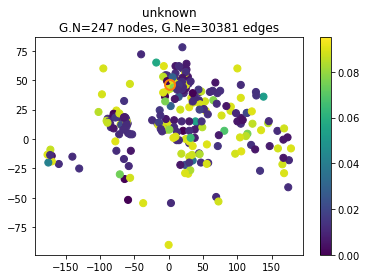

In [51]:
# Get the position of the nodes
c_data = pickle.load(open('DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)
countries = c_data.index.tolist()


weights_df = pd.DataFrame(weights,columns=countries,index=c_data.index.tolist())

country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)
country_pos = np.transpose(np.vstack((country_pos[:,1], country_pos[:,0])))

# Create the graph
G = graphs.Graph(weights_df.as_matrix())

G.set_coordinates(country_pos)
G.compute_fourier_basis()

# Create the heat diffusion filter
filt = filters.Heat(G, tau=100)


# Create the signal for a given country
for NODE, country in enumerate(weights_df.index):
    
    signal = np.zeros(G.N)
    signal[NODE] = 10

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)
    
   
    if NODE > 0:
        filtered_signals = np.vstack((filtered_signals, filtered_s))
    else : 
        filtered_signals = filtered_s
    
    if country == "France":
        # Plot the signal on the graph
        G.plot_signal(filtered_s, vertex_size=50, highlight=NODE)

filtered_signals = np.transpose(filtered_signals)


Here we can see more clearly what is going on (with the dots placed at the center of each country). There does not seem to be any logic to the madness... (reminder the event happens in France in this hypothetical scneario)


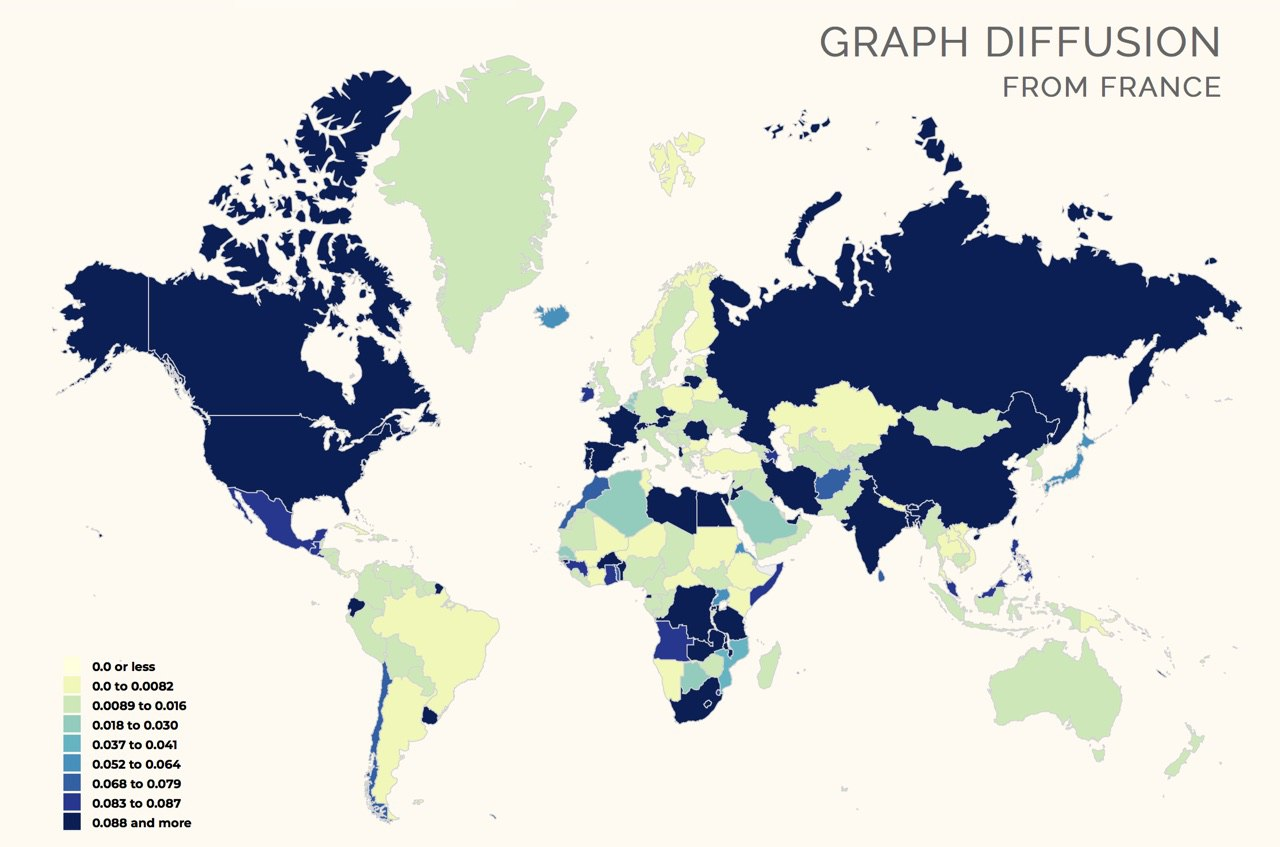

In [55]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "NMF_France.png"), width=1000)

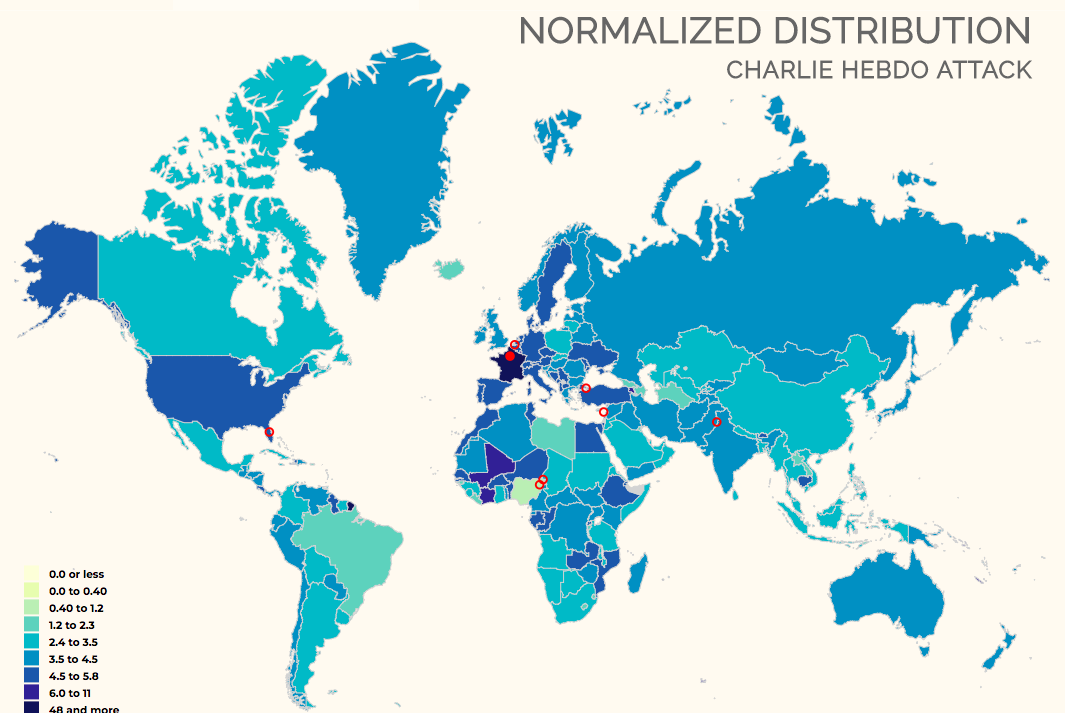

In [53]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "Charlie_hebdo.png"), width=1000)

The discrepancies speak for themselves.

To visualize this for other countries please refer to the interactive plot on the data-story.

____

## 4.4. Regression Model To Predict Reaction Levels

We decided to attempt a regression model, knowing full well that we do not have enough datapoints to obtain pertinent results ("qui tente rien n'a rien"). In the present case we would like to have a model which would predict the reaction of all countries to an event in a specific country. The issue with this is that we need to have a multi-regressor which will compute a regression model for each of the countries. This means that we will have 247 regression models in total. To do so would have ideally required a minimum of 1000 events.

Unsurprisingly, the results were sub-par. 

____

## 4.5. Using Random Search To Optimize Mixing Weights

____
____
____

# 5. Critical Assessment and Conclusion

The goal of this project was to determine whether a set of simple metrics could be used to create a model which would adequately represent the links between countries and predict the reactions towards specific events on social media.


As we have shown the problem is far more complex than one would have hoped. Twitter is inherently biased because it is a social media plateform. This implies that people are not necessarily subscribed to the network, and if they are that they are active on network. In general social media is relatively new and tends to attract younger generations which are generally less aware about what is going on not only around the world but even in their immediate environment.


When people tweet they do not necessarily provide their location and this may also be cultural. Depending on the countries, people are more or less aware of the dangers of providing their locations on social media and therefore more or less inclined to provide personal information in general. This was partially corrected by using a normalizing factor with the tweets but is still an inherent bias in the original dataset.

The absence of reaction to an event on social media does not necessarily imply that people are not interested in what is going on. We assume that the proportion of people who react to an event is always the same with respect to the overall number of tweeters


Not having standardized locations required creating a mapping which in itself is imperfect and implies loss of a given amount of data. 


Our metrics are also imperfect and can difficultly model on their own a complex system which is highly linked to social and behavioural aspects. 


Furthermore, creating a model requires much more data than what we had at hand, both in terms of number of tweets and in terms of events analyzed. 


For all of these reasons it was evident that creating a metric would be challenging. In general it would seem that we need much more complex pararmeters to describe our system than the ones we have currently in order to correclty predict what is going on especially since awareness does not necessarily imply reaction.


**TODO / NOTE TO BE CONTEMPLATED FOR CONCLUSION TO THE WORST: to see if the fact that the country is very large with a large population that can diminish the interest compared to what is happening elsewhere in the world**

____
____
____

# 6. Data Story



For the Data story we have decided to use the possibilities of Github Pages and Jekyll in order to create a beautiful Data Story. We used for that a template exploiting Bootstrap : [GrayScale](https://github.com/jeromelachaud/grayscale-theme). 

For the Interactive Maps visualization, we used several tools written in Javascript, including  [GrayScale](https://github.com/jeromelachaud/grayscale-theme). 

For the Interactive Maps visualization, we used several tools written in Javascript, including D3.js , Topojson.js  and adional D3 extensions. Note that all the bins are Jenks Natural Breaks computed with ckmeans from the simple statistics package for d3.js . 

Enjoy 🙂 

[Tweet Awareness](http://tweet-awareness.eu).


____
____
____
# 7. Contributions

We summarized the contributions of each of the members in the following table where green refers to major contributions and yellow to minor contributions. 

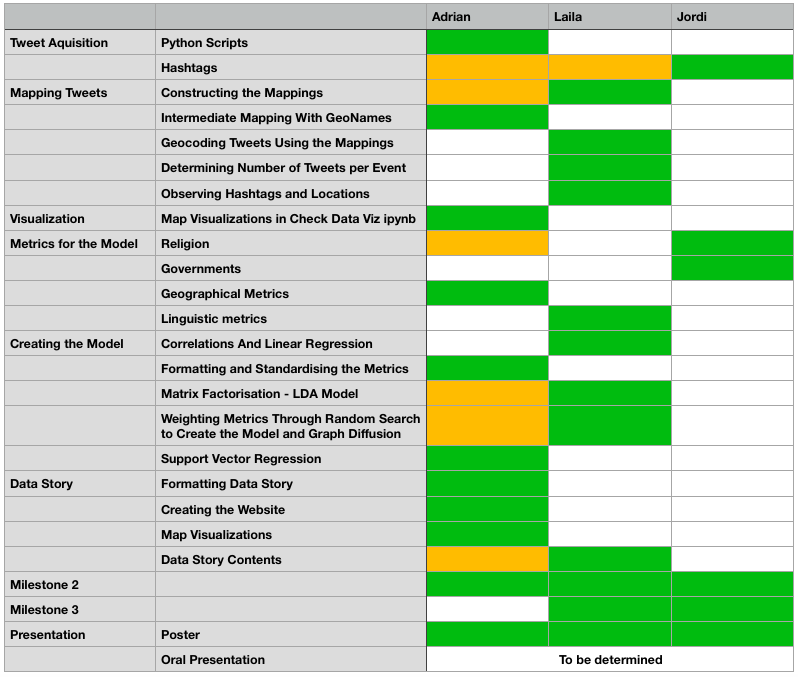

In [54]:
Image(filename=os.path.join(os.getcwd(), 'Visualization', "member_contributions.png"), width=700)